In [1]:
# Importing Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import sklearn.model_selection as skm
from functools import reduce
from itertools import chain
from scipy.stats import pearsonr, spearmanr

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Lasso, LassoCV
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l1_l2

import openai
import re
import os
from dotenv import load_dotenv

from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX



pd.options.display.max_rows = None  # Show all rows
pd.options.display.max_columns = None  # Show all columns
pd.options.display.max_colwidth = None  # Ensure full content is visible
pd.set_option('display.float_format', '{:.6f}'.format)  # Adjust decimal places as needed

In [2]:
aapl_data = pd.read_csv("full_complete_datasets/AAPL_raw_complete_data.csv")

aapl_data.describe()

C:\Users\ekf98\AppData\Local\Temp\ipykernel_28540\3292689322.py:1: DtypeWarning: Columns (12,13,69,81,93,105,117,129,141,155,167,168,169) have mixed types. Specify dtype option on import or set low_memory=False.
  aapl_data = pd.read_csv("full_complete_datasets/AAPL_raw_complete_data.csv")


,AAPL_close,AAPL_high,AAPL_low,AAPL_open,AAPL_traded_volume,AAPL_adjClose,AAPL_adjLow,AAPL_adjOpen,AAPL_adj_traded_volume,AAPL_divCash,AAPL_splitFactor,pe,basicMaterialsChangesPercentage,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,financialServicesChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month2,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,CADUSD_open,CADUSD_high,CADUSD_low,CADUSD_close,CADUSD_adjClose,CADUSD_traded_volume,CADUSD_unadjusted_traded_Volume,CADUSD_change,CADUSD_changePercent,CADUSD_vwap,CADUSD_changeOverTime,CHFUSD_open,CHFUSD_high,CHFUSD_low,CHFUSD_close,CHFUSD_adjClose,CHFUSD_traded_volume,CHFUSD_unadjusted_traded_Volume,CHFUSD_change,CHFUSD_changePercent,CHFUSD_vwap,CHFUSD_changeOverTime,CNHUSD_open,CNHUSD_high,CNHUSD_low,CNHUSD_close,CNHUSD_adjClose,CNHUSD_traded_volume,CNHUSD_unadjusted_traded_Volume,CNHUSD_change,CNHUSD_changePercent,CNHUSD_vwap,CNHUSD_changeOverTime,KRWUSD_open,KRWUSD_high,KRWUSD_low,KRWUSD_close,KRWUSD_adjClose,KRWUSD_traded_volume,KRWUSD_unadjusted_traded_Volume,KRWUSD_change,KRWUSD_changePercent,KRWUSD_vwap,KRWUSD_changeOverTime,EURUSD_open,EURUSD_high,EURUSD_low,EURUSD_close,EURUSD_adjClose,EURUSD_traded_volume,EURUSD_unadjusted_traded_Volume,EURUSD_change,EURUSD_changePercent,EURUSD_vwap,EURUSD_changeOverTime,GBPUSD_open,GBPUSD_high,GBPUSD_low,GBPUSD_close,GBPUSD_adjClose,GBPUSD_traded_volume,GBPUSD_unadjusted_traded_Volume,GBPUSD_change,GBPUSD_changePercent,GBPUSD_vwap,GBPUSD_changeOverTime,JPYUSD_open,JPYUSD_high,JPYUSD_low,JPYUSD_close,JPYUSD_adjClose,JPYUSD_traded_volume,JPYUSD_unadjusted_traded_Volume,JPYUSD_change,JPYUSD_changePercent,JPYUSD_vwap,JPYUSD_changeOverTime,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor
count,11384.000000,11384.000000,11384.000000,11384.000000,11384.000000,11384.000000,11384.000000,11384.000000,11384.000000,11384.000000,11384.000000,6529.000000,0.000000,5037.000000,5037.000000,5037.000000,5037.000000,0.000000,5037.000000,5037.000000,5037.000000,5037.000000,5037.000000,6077.000000,1639.000000,9022.000000,9025.000000,9025.000000,9025.000000,9025.000000,9025.000000,9025.000000,9025.000000,8075.000000,7998.000000,5716.000000,10161.000000,10161.000000,10161.000000,10161.000000,9427.000000,9427.000000,9427.000000,9427.000000,3793.000000,3793.000000,3793.000000,3793.000000,10589.000000,10589.000000,10589.000000,10589.000000,11285.000000,11285.000000,11285.000000,11285.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,11380.000000,113

# Data Cleaning & Preprocessing

In [11]:
aapl_duplicates = aapl_data.duplicated()
print("Duplicate rows in your data: ")
aapl_duplicates.value_counts()

Duplicate rows in your data: 


False    11253
True       131
Name: count, dtype: int64

In [12]:
df_duplicates_rows = aapl_data[aapl_data.duplicated(keep=False)]

# Displaying examples of duplicated rows
df_duplicates_rows.head(10)

,date,AAPL_close,AAPL_high,AAPL_low,AAPL_open,AAPL_traded_volume,AAPL_adjClose,AAPL_adjLow,AAPL_adjOpen,AAPL_adj_traded_volume,AAPL_divCash,AAPL_splitFactor,sector,exchange,pe,basicMaterialsChangesPercentage,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,financialServicesChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month2,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,CADUSD_open,CADUSD_high,CADUSD_low,CADUSD_close,CADUSD_adjClose,CADUSD_traded_volume,CADUSD_unadjusted_traded_Volume,CADUSD_change,CADUSD_changePercent,CADUSD_vwap,CADUSD_label,CADUSD_changeOverTime,CHFUSD_open,CHFUSD_high,CHFUSD_low,CHFUSD_close,CHFUSD_adjClose,CHFUSD_traded_volume,CHFUSD_unadjusted_traded_Volume,CHFUSD_change,CHFUSD_changePercent,CHFUSD_vwap,CHFUSD_label,CHFUSD_changeOverTime,CNHUSD_open,CNHUSD_high,CNHUSD_low,CNHUSD_close,CNHUSD_adjClose,CNHUSD_traded_volume,CNHUSD_unadjusted_traded_Volume,CNHUSD_change,CNHUSD_changePercent,CNHUSD_vwap,CNHUSD_label,CNHUSD_changeOverTime,KRWUSD_open,KRWUSD_high,KRWUSD_low,KRWUSD_close,KRWUSD_adjClose,KRWUSD_traded_volume,KRWUSD_unadjusted_traded_Volume,KRWUSD_change,KRWUSD_changePercent,KRWUSD_vwap,KRWUSD_label,KRWUSD_changeOverTime,EURUSD_open,EURUSD_high,EURUSD_low,EURUSD_close,EURUSD_adjClose,EURUSD_traded_volume,EURUSD_unadjusted_traded_Volume,EURUSD_change,EURUSD_changePercent,EURUSD_vwap,EURUSD_label,EURUSD_changeOverTime,GBPUSD_open,GBPUSD_high,GBPUSD_low,GBPUSD_close,GBPUSD_adjClose,GBPUSD_traded_volume,GBPUSD_unadjusted_traded_Volume,GBPUSD_change,GBPUSD_changePercent,GBPUSD_vwap,GBPUSD_label,GBPUSD_changeOverTime,JPYUSD_open,JPYUSD_high,JPYUSD_low,JPYUSD_close,JPYUSD_adjClose,JPYUSD_traded_volume,JPYUSD_unadjusted_traded_Volume,JPYUSD_change,JPYUSD_changePercent,JPYUSD_vwap,JPYUSD_label,JPYUSD_changeOverTime,symbol,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,AAPL_stock_news_sentiment,AAPL_press_release_sentiment,AAPL_twitter_social_sentiment,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,NVDA_stock_news_sentiment,NVDA_press_release_sentiment,NVDA_twitter_social_sentiment
2333,1990-03-09,36.880000,37.500000,36.250000,36.750000,2057800,0.260040,0.255598,0.259123,230473830,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.260000,8.330000,8.460000,8.730000,8.710000,8.680000,8.710000,8.650000,NaN,8.630000,NaN,131.900000,0.000000,131.900000,131.900000,1.155000,0.000000,1.155000,1.155000,NaN,NaN,NaN,NaN,5.100000,0.000000,5.100000,5.100000,399.300000,0.000000,399.300000,399.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.329240,100.000000,0.329240,0.329240,100.000000,0.000000,0.329240,-50.000000,0.329240,neutral,neutral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2334,1990-03-09,36.880000,37.500000,36.250000,36.750000,2057800,0.260040,0.255598,0.259123,230473830,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.260000,8.330000,8.460000,8.730000,8.710000,8.680000,8.710000,8.650000,NaN,8.630000,NaN,131.900000,0.000000,131.900000,131.900000,1.155000,0.000000,1.155000,1.155000,NaN,NaN,NaN,NaN,5.100000,0.000000,5.100000,5.100

In [13]:
# dropping all duplicates
aapl_data = aapl_data.drop_duplicates()

# converting date column to datetime
aapl_data['date'] = pd.to_datetime(aapl_data['date'], format="%Y-%m-%d")

In [14]:
aapl_data.head()

,date,AAPL_close,AAPL_high,AAPL_low,AAPL_open,AAPL_traded_volume,AAPL_adjClose,AAPL_adjLow,AAPL_adjOpen,AAPL_adj_traded_volume,AAPL_divCash,AAPL_splitFactor,sector,exchange,pe,basicMaterialsChangesPercentage,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,financialServicesChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month2,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,CADUSD_open,CADUSD_high,CADUSD_low,CADUSD_close,CADUSD_adjClose,CADUSD_traded_volume,CADUSD_unadjusted_traded_Volume,CADUSD_change,CADUSD_changePercent,CADUSD_vwap,CADUSD_label,CADUSD_changeOverTime,CHFUSD_open,CHFUSD_high,CHFUSD_low,CHFUSD_close,CHFUSD_adjClose,CHFUSD_traded_volume,CHFUSD_unadjusted_traded_Volume,CHFUSD_change,CHFUSD_changePercent,CHFUSD_vwap,CHFUSD_label,CHFUSD_changeOverTime,CNHUSD_open,CNHUSD_high,CNHUSD_low,CNHUSD_close,CNHUSD_adjClose,CNHUSD_traded_volume,CNHUSD_unadjusted_traded_Volume,CNHUSD_change,CNHUSD_changePercent,CNHUSD_vwap,CNHUSD_label,CNHUSD_changeOverTime,KRWUSD_open,KRWUSD_high,KRWUSD_low,KRWUSD_close,KRWUSD_adjClose,KRWUSD_traded_volume,KRWUSD_unadjusted_traded_Volume,KRWUSD_change,KRWUSD_changePercent,KRWUSD_vwap,KRWUSD_label,KRWUSD_changeOverTime,EURUSD_open,EURUSD_high,EURUSD_low,EURUSD_close,EURUSD_adjClose,EURUSD_traded_volume,EURUSD_unadjusted_traded_Volume,EURUSD_change,EURUSD_changePercent,EURUSD_vwap,EURUSD_label,EURUSD_changeOverTime,GBPUSD_open,GBPUSD_high,GBPUSD_low,GBPUSD_close,GBPUSD_adjClose,GBPUSD_traded_volume,GBPUSD_unadjusted_traded_Volume,GBPUSD_change,GBPUSD_changePercent,GBPUSD_vwap,GBPUSD_label,GBPUSD_changeOverTime,JPYUSD_open,JPYUSD_high,JPYUSD_low,JPYUSD_close,JPYUSD_adjClose,JPYUSD_traded_volume,JPYUSD_unadjusted_traded_Volume,JPYUSD_change,JPYUSD_changePercent,JPYUSD_vwap,JPYUSD_label,JPYUSD_changeOverTime,symbol,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,AAPL_stock_news_sentiment,AAPL_press_release_sentiment,AAPL_twitter_social_sentiment,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,NVDA_stock_news_sentiment,NVDA_press_release_sentiment,NVDA_twitter_social_sentiment
0,1980-12-12,28.750000,28.870000,28.750000,28.750000,2093900,0.098974,0.098974,0.098974,469034069,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,562.750000,0.000000,562.750000,562.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neutral,neutral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1980-12-15,27.250000,27.380000,27.250000,27.380000,785200,0.093810,0.093810,0.094258,175884975,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,579.000000,0.000000,579.000000,579.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [15]:
aapl_data.columns

Index(['date', 'AAPL_close', 'AAPL_high', 'AAPL_low', 'AAPL_open',
       'AAPL_traded_volume', 'AAPL_adjClose', 'AAPL_adjLow', 'AAPL_adjOpen',
       'AAPL_adj_traded_volume',
       ...
       'NVDA_traded_volume', 'NVDA_adjClose', 'NVDA_adjLow', 'NVDA_adjOpen',
       'NVDA_adj_traded_volume', 'NVDA_divCash', 'NVDA_splitFactor',
       'NVDA_stock_news_sentiment', 'NVDA_press_release_sentiment',
       'NVDA_twitter_social_sentiment'],
      dtype='object', length=170)

In [16]:
# These columns just represents the company's symbol and currency labels and is not useful so we drop it
aapl_data.drop(columns= ['symbol', 'CADUSD_label', 'KRWUSD_label', 'CNHUSD_label', 'GBPUSD_label', 'JPYUSD_label', 'EURUSD_label', 'CHFUSD_label', 'sector', 'exchange'], inplace=True)

In [17]:
# Restricting the data to start from 1999 for Apple. 
# Reasons being other features do not go far back as 1980 and data all the way back to 1980 becomes less relevant to predict the next three weeks forecast. Hence, we match it to the starting date for Nvidia
aapl_data = aapl_data[aapl_data['date']>= '1999-01-22']

aapl_data.sample(10).sort_values('date')

,date,AAPL_close,AAPL_high,AAPL_low,AAPL_open,AAPL_traded_volume,AAPL_adjClose,AAPL_adjLow,AAPL_adjOpen,AAPL_adj_traded_volume,AAPL_divCash,AAPL_splitFactor,pe,basicMaterialsChangesPercentage,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,financialServicesChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month2,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,CADUSD_open,CADUSD_high,CADUSD_low,CADUSD_close,CADUSD_adjClose,CADUSD_traded_volume,CADUSD_unadjusted_traded_Volume,CADUSD_change,CADUSD_changePercent,CADUSD_vwap,CADUSD_changeOverTime,CHFUSD_open,CHFUSD_high,CHFUSD_low,CHFUSD_close,CHFUSD_adjClose,CHFUSD_traded_volume,CHFUSD_unadjusted_traded_Volume,CHFUSD_change,CHFUSD_changePercent,CHFUSD_vwap,CHFUSD_changeOverTime,CNHUSD_open,CNHUSD_high,CNHUSD_low,CNHUSD_close,CNHUSD_adjClose,CNHUSD_traded_volume,CNHUSD_unadjusted_traded_Volume,CNHUSD_change,CNHUSD_changePercent,CNHUSD_vwap,CNHUSD_changeOverTime,KRWUSD_open,KRWUSD_high,KRWUSD_low,KRWUSD_close,KRWUSD_adjClose,KRWUSD_traded_volume,KRWUSD_unadjusted_traded_Volume,KRWUSD_change,KRWUSD_changePercent,KRWUSD_vwap,KRWUSD_changeOverTime,EURUSD_open,EURUSD_high,EURUSD_low,EURUSD_close,EURUSD_adjClose,EURUSD_traded_volume,EURUSD_unadjusted_traded_Volume,EURUSD_change,EURUSD_changePercent,EURUSD_vwap,EURUSD_changeOverTime,GBPUSD_open,GBPUSD_high,GBPUSD_low,GBPUSD_close,GBPUSD_adjClose,GBPUSD_traded_volume,GBPUSD_unadjusted_traded_Volume,GBPUSD_change,GBPUSD_changePercent,GBPUSD_vwap,GBPUSD_changeOverTime,JPYUSD_open,JPYUSD_high,JPYUSD_low,JPYUSD_close,JPYUSD_adjClose,JPYUSD_traded_volume,JPYUSD_unadjusted_traded_Volume,JPYUSD_change,JPYUSD_changePercent,JPYUSD_vwap,JPYUSD_changeOverTime,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,AAPL_stock_news_sentiment,AAPL_press_release_sentiment,AAPL_twitter_social_sentiment,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,NVDA_stock_news_sentiment,NVDA_press_release_sentiment,NVDA_twitter_social_sentiment
4635,1999-03-11,32.190000,33.880000,32.000000,32.250000,4229100,0.242156,0.240727,0.242607,473659673,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.620000,4.690000,4.770000,5.050000,5.110000,5.130000,5.350000,5.210000,5.870000,5.570000,NaN,349.000000,140.000000,345.500000,349.000000,0.631000,7919.000000,0.638000,0.631000,NaN,NaN,NaN,NaN,5.355000,0.000000,5.285000,5.355000,294.450000,0.000000,293.000000,294.450000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.287390,100.000000,0.287390,0.287390,0.000000,0.000000,0.287390,-89.964158,0.287390,neutral,neutral,NaN,20.750000,21.690000,20.750000,21.310000,113100.000000,0.039649,0.039649,0.040719,54287972.000000,0.000000,1.000000,neutral,neutral,NaN
6108,2004-11-09,54.050000,54.550000,53.380000,54.200000,8495800,0.813205,0.803125,0.815462,475765275,0.000000,1.000000,60.203551,NaN,-0.362460,4.457810,0.035490,-0.867460,NaN,-0.428540,1.467880,0.167510,3.332000,0.123630,1.890000,NaN,2.080000,2.290000,2.460000,2.800000,3.050000,3.530000,3.880000,4.220000,4.950000,NaN,2.480000,215.450000,545.000000,218.400000,215.450000,1.375500,8155.000000,1.361500,1.375500,NaN,NaN,NaN,NaN,7.510000,0.000000,7.455000,7.510000,435

In [18]:
# Function to obtain percentages of missing values 
def percent_missing(df):
    nan_percent = 100 * df.isnull().sum() / len(df)
    nan_percent = nan_percent[nan_percent > 0].sort_values(ascending=False)

    return nan_percent

# Function to plot out missing value percentages by column
def show_percent_missing(df):
    nan_percent = percent_missing(df)

    plt.figure(figsize=(24, 8))

    sns.barplot(x=nan_percent.index, y=nan_percent)
    plt.xticks(rotation=90)
    plt.ylabel('Missing Percentage %')
    plt.xlabel('Variables')

In [19]:
# Identifying values in this column that are not useful which we were generated by chat-GPT
aapl_data['NVDA_stock_news_sentiment'].unique()

array(['neutral', 'weakly_positive', 'strongly_positive',
       'weakly_negative', 'strongly_negative',
       "i'm sorry, but i cannot provide sentiment analysis for specific historical dates without direct access to news archives from that time.",
       "i'm sorry, but i can’t provide that specific information."],
      dtype=object)

In [20]:
# Replacing values that are not useful as missing 
aapl_data['AAPL_stock_news_sentiment'][aapl_data['AAPL_stock_news_sentiment'].str.contains("i'm sorry, but i", case=False, na=False)] = np.nan
aapl_data['NVDA_stock_news_sentiment'][aapl_data['NVDA_stock_news_sentiment'].str.contains("i'm sorry, but i", case=False, na=False)] = np.nan


# creating an exclusion to avoid replacing these as missing
exclusion = ['neutral', 'weakly_positive', 'weakly_negative', 'strongly_positive',  'strongly_negative']

# filling values as missing excluding those in the exclusion list
aapl_data['AAPL_press_release_sentiment'] = aapl_data['AAPL_press_release_sentiment'].apply(
    lambda x: x if x in exclusion else np.nan
)
aapl_data['NVDA_press_release_sentiment'] = aapl_data['NVDA_press_release_sentiment'].apply(
    lambda x: x if x in exclusion else np.nan
)

print(aapl_data['AAPL_stock_news_sentiment'].unique())
print(aapl_data['NVDA_stock_news_sentiment'].unique())
print(aapl_data['AAPL_press_release_sentiment'].unique())
print(aapl_data['NVDA_press_release_sentiment'].unique())


['neutral' 'weakly_positive' 'weakly_negative' 'strongly_positive'
 'strongly_negative']
['neutral' 'weakly_positive' 'strongly_positive' 'weakly_negative'
 'strongly_negative' nan]
['weakly_positive' 'neutral' 'strongly_positive' 'weakly_negative'
 'strongly_negative' nan]
['neutral' 'strongly_positive' 'weakly_positive' 'weakly_negative'
 'strongly_negative' nan]


In [21]:
# Creating a year and month column
aapl_data['month'] = aapl_data['date'].dt.month
aapl_data['year'] = aapl_data['date'].dt.year


# creating a function to classify the months based on the season
def season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3,4,5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
    

# Creating a season column 
aapl_data['season'] = aapl_data['month'].apply(season)

aapl_data[['date', 'year', 'month', 'season']].sample(20)

,date,year,month,season
10570,2022-01-07,2022,1,Winter
9678,2018-07-30,2018,7,Summer
11007,2023-09-14,2023,9,Fall
6813,2007-07-31,2007,7,Summer
10373,2021-04-13,2021,4,Spring
8829,2015-04-24,2015,4,Spring
9248,2016-11-29,2016,11,Fall
7752,2011-03-04,2011,3,Spring
7504,2010-03-19,2010,3,Spring
9539,2018-01-18,2018,1,Winter


In [ ]:
# # Creating Subplots Grid

# fig, axes = plt.subplots(nrows=(len(aapl_data.columns) // 3) + 1, ncols=3, figsize=(15, 5 * ((len(aapl_data.columns) // 3) + 1)))

# # Flattening axes for easy iteration
# axes = axes.flatten()

# # plotting each numeric column against 'SalePrice'
# for i, col in enumerate(aapl_data.columns):
#     sns.scatterplot(x=aapl_data[col], y =aapl_data['AAPL_adjClose'], ax=axes[i])
#     axes[i].set_title(f'{col} vs AAPL_adjClose')

# # Hiding any extra subplots where numeric columns are not a multiple of 3
# for i in range(len(aapl_data.columns), len(axes)):
#     fig.delaxes(axes[i])

# plt.tight_layout()
# plt.show()

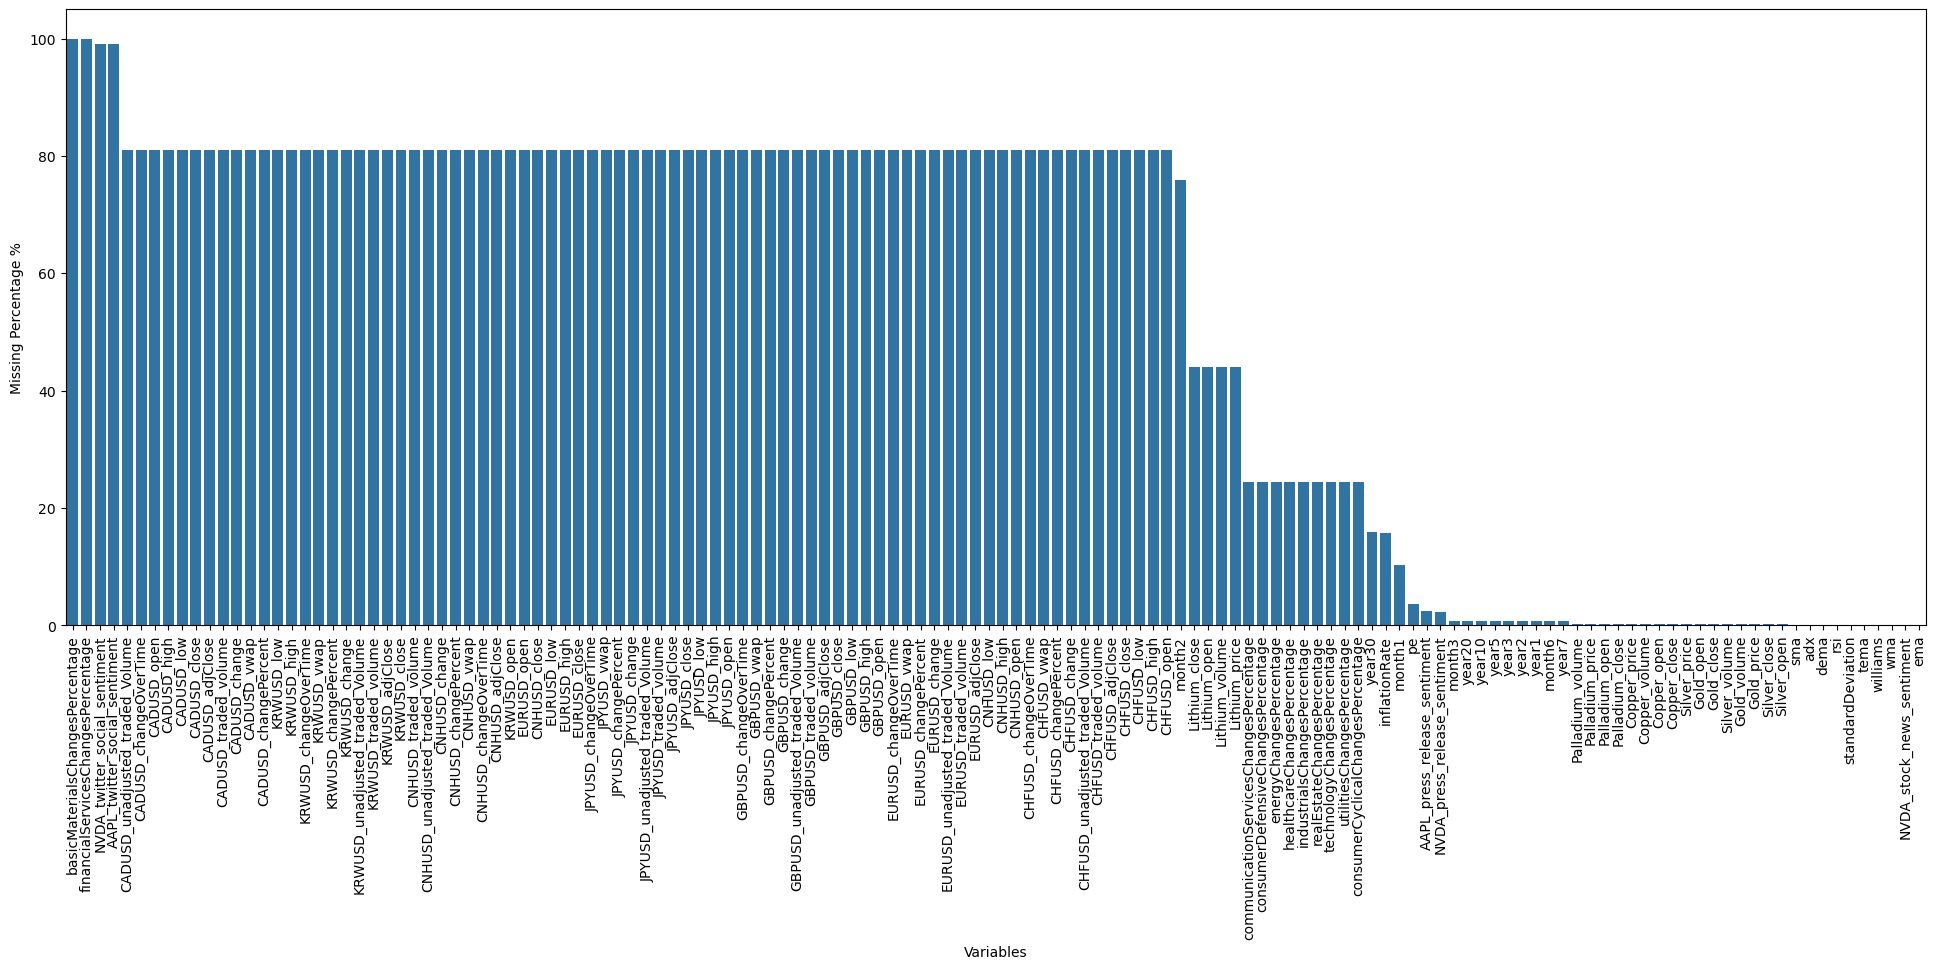

In [23]:
show_percent_missing(aapl_data)

In [24]:
percent_missing(aapl_data)

basicMaterialsChangesPercentage          100.000000
financialServicesChangesPercentage       100.000000
NVDA_twitter_social_sentiment             99.100045
AAPL_twitter_social_sentiment             99.100045
CADUSD_unadjusted_traded_Volume           80.935953
CADUSD_changeOverTime                     80.935953
CADUSD_open                               80.935953
CADUSD_high                               80.935953
CADUSD_low                                80.935953
CADUSD_close                              80.935953
CADUSD_adjClose                           80.935953
CADUSD_traded_volume                      80.935953
CADUSD_change                             80.935953
CADUSD_vwap                               80.935953
CADUSD_changePercent                      80.935953
KRWUSD_low                                80.920954
KRWUSD_high                               80.920954
KRWUSD_changeOverTime                     80.920954
KRWUSD_vwap                               80.920954
KRWUSD_chang

In [25]:
nan_percent = 100 * aapl_data.isnull().sum() / len(aapl_data)
nan_percent = nan_percent[nan_percent > 0].sort_values(ascending=False)

cols_to_drop = nan_percent[nan_percent >= 75].index

aapl_data.drop(columns=cols_to_drop, inplace=True)

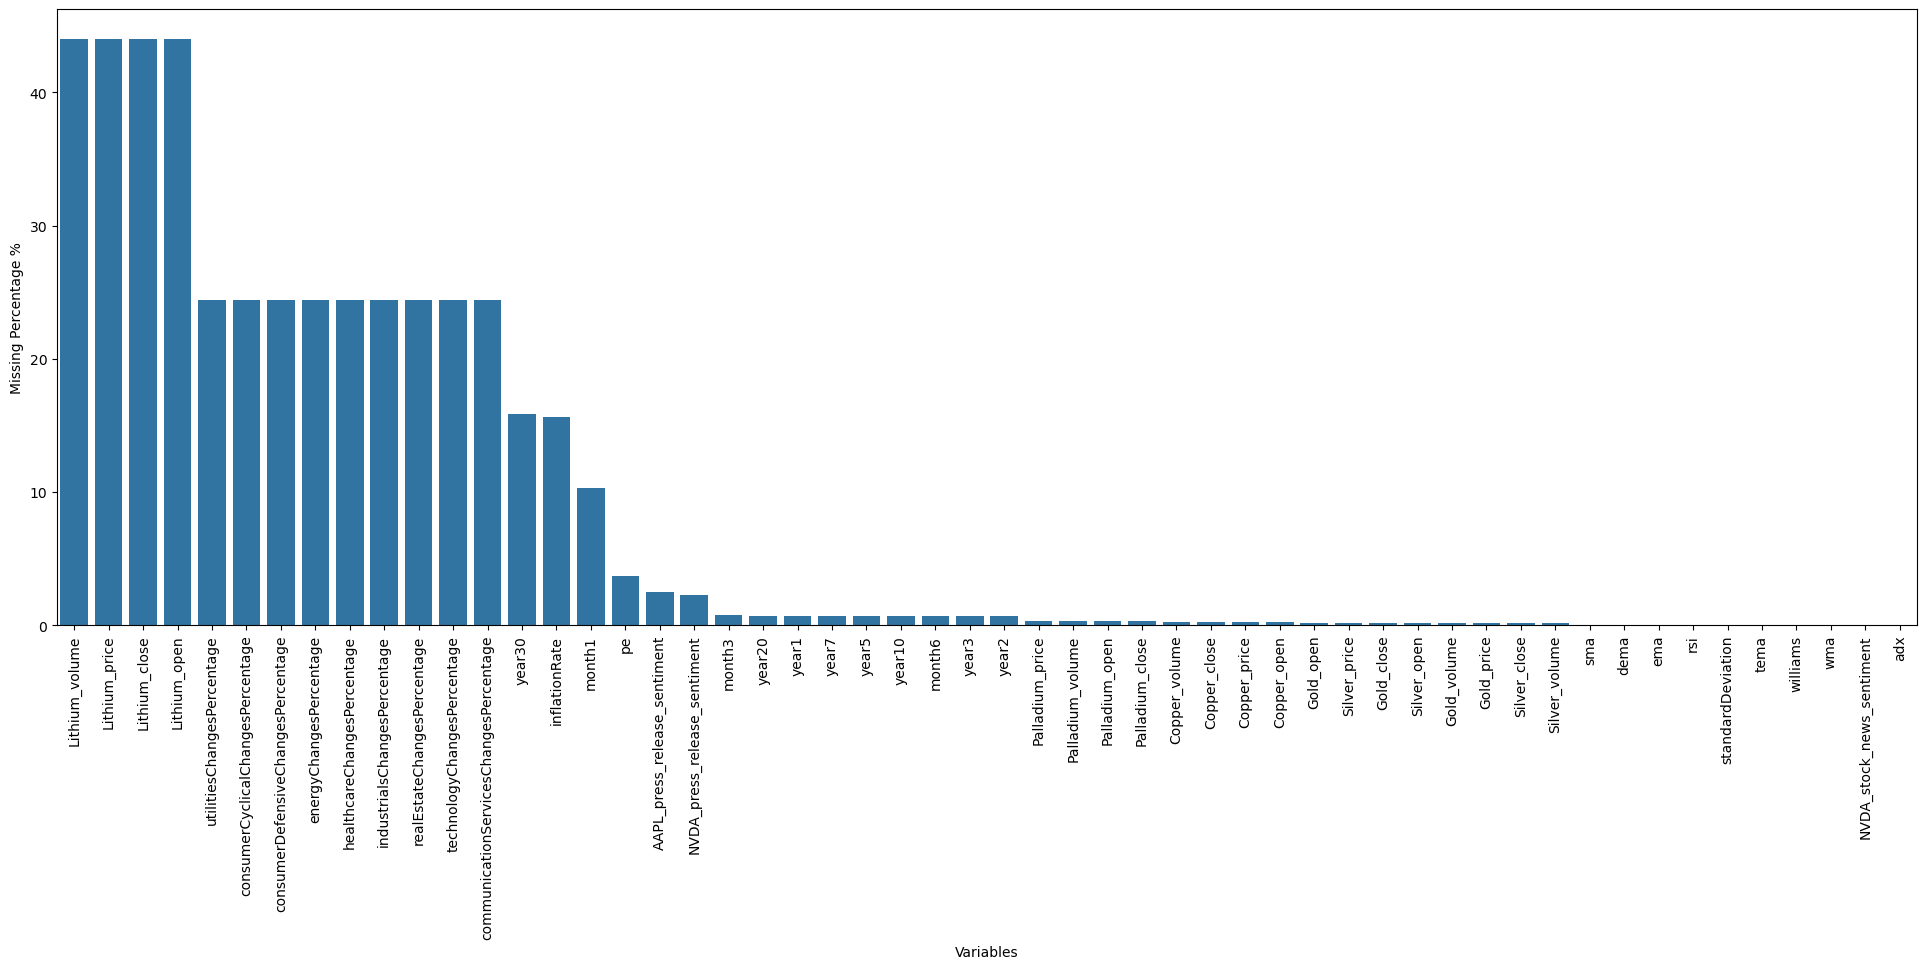

In [26]:
show_percent_missing(aapl_data)

In [27]:
percent_missing(aapl_data)

Lithium_volume                           44.037798
Lithium_price                            44.037798
Lithium_close                            44.037798
Lithium_open                             44.037798
utilitiesChangesPercentage               24.448778
consumerCyclicalChangesPercentage        24.448778
consumerDefensiveChangesPercentage       24.448778
energyChangesPercentage                  24.448778
healthcareChangesPercentage              24.448778
industrialsChangesPercentage             24.448778
realEstateChangesPercentage              24.448778
technologyChangesPercentage              24.448778
communicationServicesChangesPercentage   24.448778
year30                                   15.839208
inflationRate                            15.644218
month1                                   10.319484
pe                                        3.689816
AAPL_press_release_sentiment              2.474876
NVDA_press_release_sentiment              2.234888
month3                         

In [29]:
# Filling missing values of AAPL_stock_news_sentiment with mode by each year and month
aapl_data['AAPL_stock_news_sentiment']  = aapl_data.groupby(['year', 'month'])['AAPL_stock_news_sentiment'].transform(lambda value: value.fillna(value.mode().iloc[0]))

# Filling missing values of NVDA_stock_news_sentiment with mode by each year and month
aapl_data['NVDA_stock_news_sentiment']  = aapl_data.groupby(['year', 'month'])['NVDA_stock_news_sentiment'].transform(lambda value: value.fillna(value.mode().iloc[0]))

# Filling missing values of AAPL_press_release_statement with mode by each year and month
aapl_data['AAPL_press_release_sentiment']  = aapl_data.groupby(['year', 'month'])['AAPL_press_release_sentiment'].transform(lambda value: value.fillna(value.mode().iloc[0]))

# Filling missing values of NVDA_press_release_sentiment with mode by each year and month
aapl_data['NVDA_press_release_sentiment']  = aapl_data.groupby(['year', 'month'])['NVDA_press_release_sentiment'].transform(lambda value: value.fillna(value.mode().iloc[0]))


# Grouping by year and month or just the year and then filling with the mode or median
def fill_values(feature, dataset):

    dataset[feature] = dataset.groupby(['year', 'month'])[feature].transform(lambda value: value.fillna(value.median()))

    if dataset[feature].isnull().any():
        dataset[feature] = dataset.groupby('year')[feature].transform(lambda value: value.fillna(value.median()))
        

cols_to_fill = ['Gold_volume', 'Gold_close', 'Gold_open', 'Gold_price', 'Copper_close','Copper_price',
                'Copper_volume', 'Copper_open', 'Palladium_price', 'Palladium_volume', 'Palladium_open',
                'Palladium_close', 'Silver_close', 'Silver_open', 'Silver_volume', 'Silver_price',
                'Lithium_volume', 'Lithium_close', 'Lithium_open', 'Lithium_price', 'sma', 'adx', 'dema',
                'ema', 'rsi', 'standardDeviation', 'tema', 'williams', 'wma', 'month3', 'year3', 'year5',
                'year7', 'year10', 'year20', 'year2', 'year1', 'month6', 'realEstateChangesPercentage',
                'utilitiesChangesPercentage', 'communicationServicesChangesPercentage', 'technologyChangesPercentage',
                'industrialsChangesPercentage', 'healthcareChangesPercentage', 'energyChangesPercentage',  
                'consumerDefensiveChangesPercentage', 'consumerCyclicalChangesPercentage', 'year30',
                'inflationRate', 'month1', 'pe']

# Filling columns as defined in function
for col in cols_to_fill:
    fill_values(col, aapl_data)


# Filling inflation rate and interest rates with their respective medians
aapl_data['inflationRate'] = aapl_data['inflationRate'].fillna(aapl_data['inflationRate'].median())
aapl_data['year30'] = aapl_data['year30'].fillna(aapl_data['year30'].median())
aapl_data['month1'] = aapl_data['month1'].fillna(aapl_data['month1'].median())

In [30]:
percent_missing(aapl_data)

Lithium_price    41.907905
Lithium_volume   41.907905
Lithium_open     41.907905
Lithium_close    41.907905
dtype: float64

In [31]:
# Select only numerical columns
numeric_data = aapl_data.select_dtypes(include=['float64', 'int32', 'int64'])

# Compute correlation of 'Lithium_price' with all other numeric columns
lithium_corr = numeric_data.corr()['Lithium_price'].dropna()

# Compute correlation of 'Lithium_close' with all other numeric columns
lithium_close = numeric_data.corr()['Lithium_close'].dropna()

# Compute correlation of 'Lithium_open' with all other numeric columns
lithium_open = numeric_data.corr()['Lithium_open'].dropna()

# Compute correlation of 'Lithium_open' with all other numeric columns
lithium_vol = numeric_data.corr()['Lithium_volume'].dropna()

# Filter only correlations with absolute value > 0.70
strong_corr = lithium_corr[abs(lithium_corr) > 0.70]

strong_corr_close = lithium_close[abs(lithium_close) > 0.70]

strong_corr_open = lithium_open[abs(lithium_open) > 0.70]

strong_corr_vol = lithium_vol[abs(lithium_vol) > 0.50]


# Print correlation values sorted in descending order
print(strong_corr.sort_values(ascending=False, key=abs), strong_corr_close.sort_values(ascending=False, key=abs), 
      strong_corr_open.sort_values(ascending=False, key=abs), strong_corr_vol.sort_values(ascending=False, key=abs))

Lithium_price   1.000000
Lithium_close   1.000000
Lithium_open    0.999542
Copper_price    0.709389
Copper_close    0.709389
Copper_open     0.707831
Name: Lithium_price, dtype: float64 Lithium_price   1.000000
Lithium_close   1.000000
Lithium_open    0.999542
Copper_price    0.709389
Copper_close    0.709389
Copper_open     0.707831
Name: Lithium_close, dtype: float64 Lithium_open    1.000000
Lithium_price   0.999542
Lithium_close   0.999542
Copper_price    0.709210
Copper_close    0.709210
Copper_open     0.708119
Name: Lithium_open, dtype: float64 Lithium_volume       1.000000
Lithium_open         0.697515
Lithium_close        0.697158
Lithium_price        0.697158
Palladium_open       0.633056
Palladium_price      0.631915
Palladium_close      0.631915
year                 0.568957
wma                  0.564053
sma                  0.564053
dema                 0.564053
ema                  0.564053
tema                 0.564053
AAPL_adjOpen         0.561766
AAPL_adjClose        0.

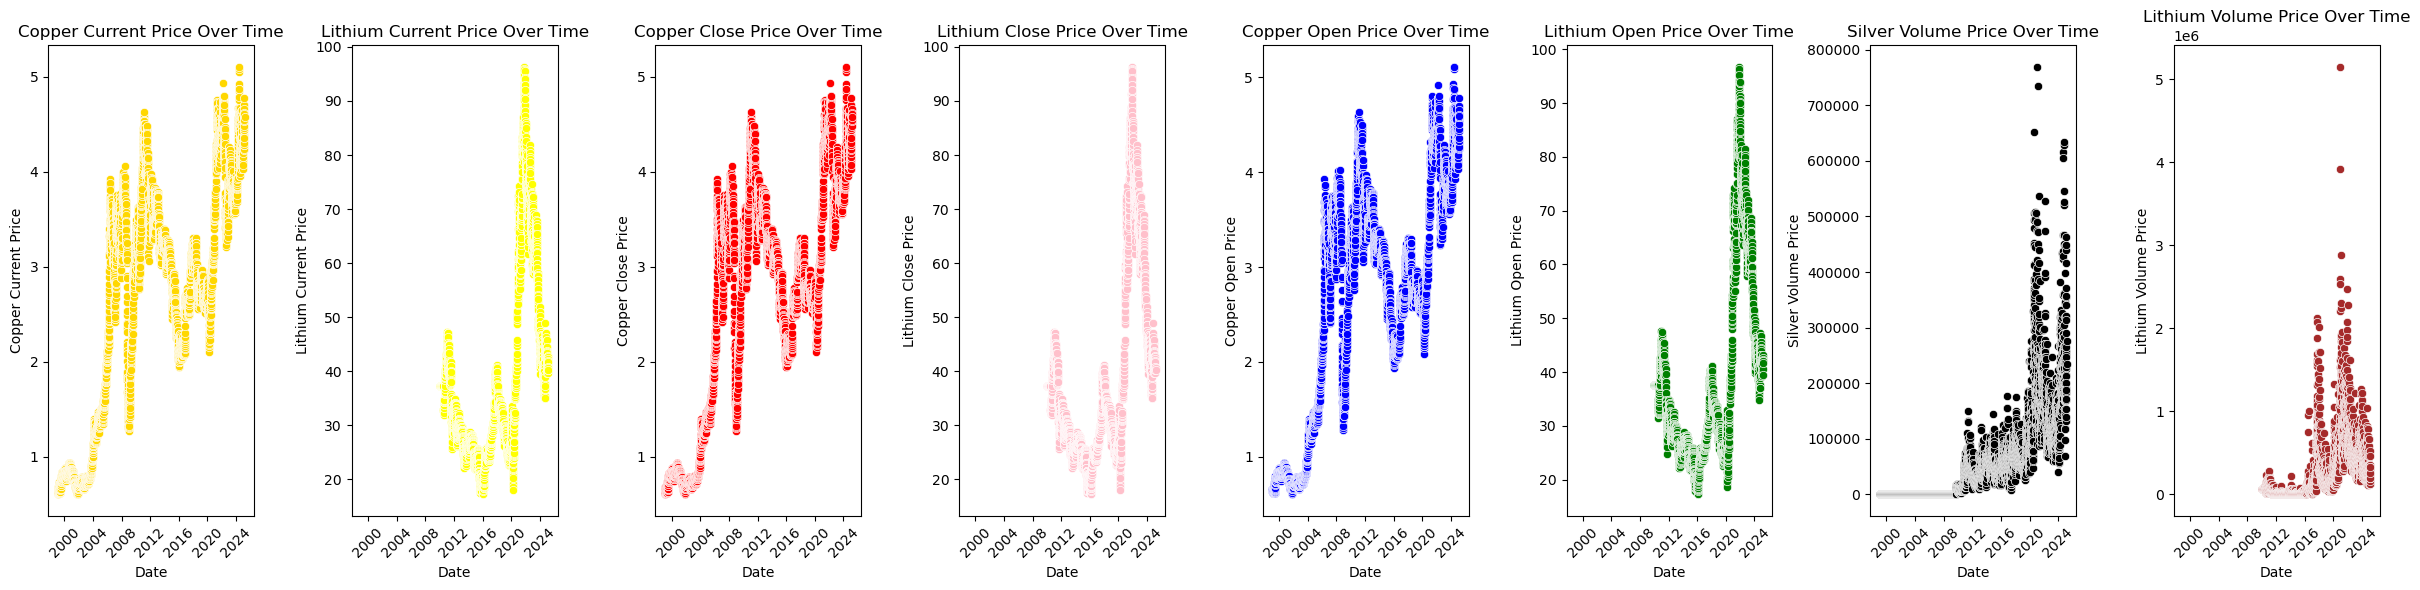

In [32]:
# Create figure and axes for two subplots side by side
fig, axes = plt.subplots(1, 8, figsize=(24, 6), sharex=True)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# First scatter plot: Gold price
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Copper_price'], ax=axes[0], color='gold')
axes[0].set_title('Copper Current Price Over Time')
axes[0].set_ylabel('Copper Current Price')

# Second scatter plot: Lithium price
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Lithium_price'], ax=axes[1], color='yellow')
axes[1].set_title('Lithium Current Price Over Time')
axes[1].set_ylabel('Lithium Current Price')

# third scatter plot: Copper_close
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Copper_close'], ax=axes[2], color='red')
axes[2].set_title('Copper Close Price Over Time')
axes[2].set_ylabel('Copper Close Price')

# fourth scatter plot: Lithium close
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Lithium_close'], ax=axes[3], color='pink')
axes[3].set_title('Lithium Close Price Over Time')
axes[3].set_ylabel('Lithium Close Price')

# fifth scatter plot: Copper_open
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Copper_open'], ax=axes[4], color='blue')
axes[4].set_title('Copper Open Price Over Time')
axes[4].set_ylabel('Copper Open Price')

# Sixth scatter plot: Lithium open
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Lithium_open'], ax=axes[5], color='green')
axes[5].set_title('Lithium Open Price Over Time')
axes[5].set_ylabel('Lithium Open Price')

# Seventh scatter plot: Copper_open
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Silver_volume'], ax=axes[6], color='black')
axes[6].set_title('Silver Volume Price Over Time')
axes[6].set_ylabel('Silver Volume Price')

# Eighth scatter plot: Lithium open
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Lithium_volume'], ax=axes[7], color='brown')
axes[7].set_title('Lithium Volume Price Over Time')
axes[7].set_ylabel('Lithium Volume Price')

# Rotate x-axis labels for better readability
for ax in axes:
    ax.set_xlabel('Date')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()  
plt.show()


In [33]:

def linear_reg_filling(col_to_fill, col_to_use, dataset):
    """ 
    col_to_fill: This is essentially the column to fill missing values on 
    col_to_use: This is the column that is trained on the linear model to create predictions on col_to_fill
    dataset: The dataset to use 
    """

    # The correlation between copper and lithium features are high (0.70). Hence, I would use a linear regression model to predict the missing values of lithium and fill them up
    # A similar correlation is shown for the other features plotted above
    from sklearn.linear_model import LinearRegression


    # Add a small constant to avoid issues with log(0)
    epsilon = 1e-5

    dataset[f"{col}_log"] = np.log(dataset[col_to_fill] + epsilon)

    # Extract rows with missing column values
    missing_data = dataset[dataset[col_to_fill].isna()]

    # Use non-missing values for fitting the regression model
    train_data = dataset.dropna(subset=[col_to_fill])

    # Reshape data to 2D (needed for sklearn)
    X_train = train_data[[col_to_use]]  # Copper as independent variable
    y_train = train_data[f"{col}_log"]  # Lithium as dependent variable

    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict Lithium values for the missing data
    X_missing = missing_data[[col_to_use]]
    predicted_col_log = model.predict(X_missing)

    # Apply inverse log transformation to predict original Lithium values
    predictions = np.exp(predicted_col_log) - epsilon

    # Fill missing Lithium values with the predicted values
    dataset.loc[dataset[col_to_fill].isna(), col_to_fill] = predictions


linear_reg_filling('Lithium_price', 'Copper_price', aapl_data)
linear_reg_filling('Lithium_close', 'Copper_close', aapl_data)
linear_reg_filling('Lithium_open', 'Copper_open', aapl_data)
linear_reg_filling('Lithium_volume', 'Silver_volume', aapl_data)

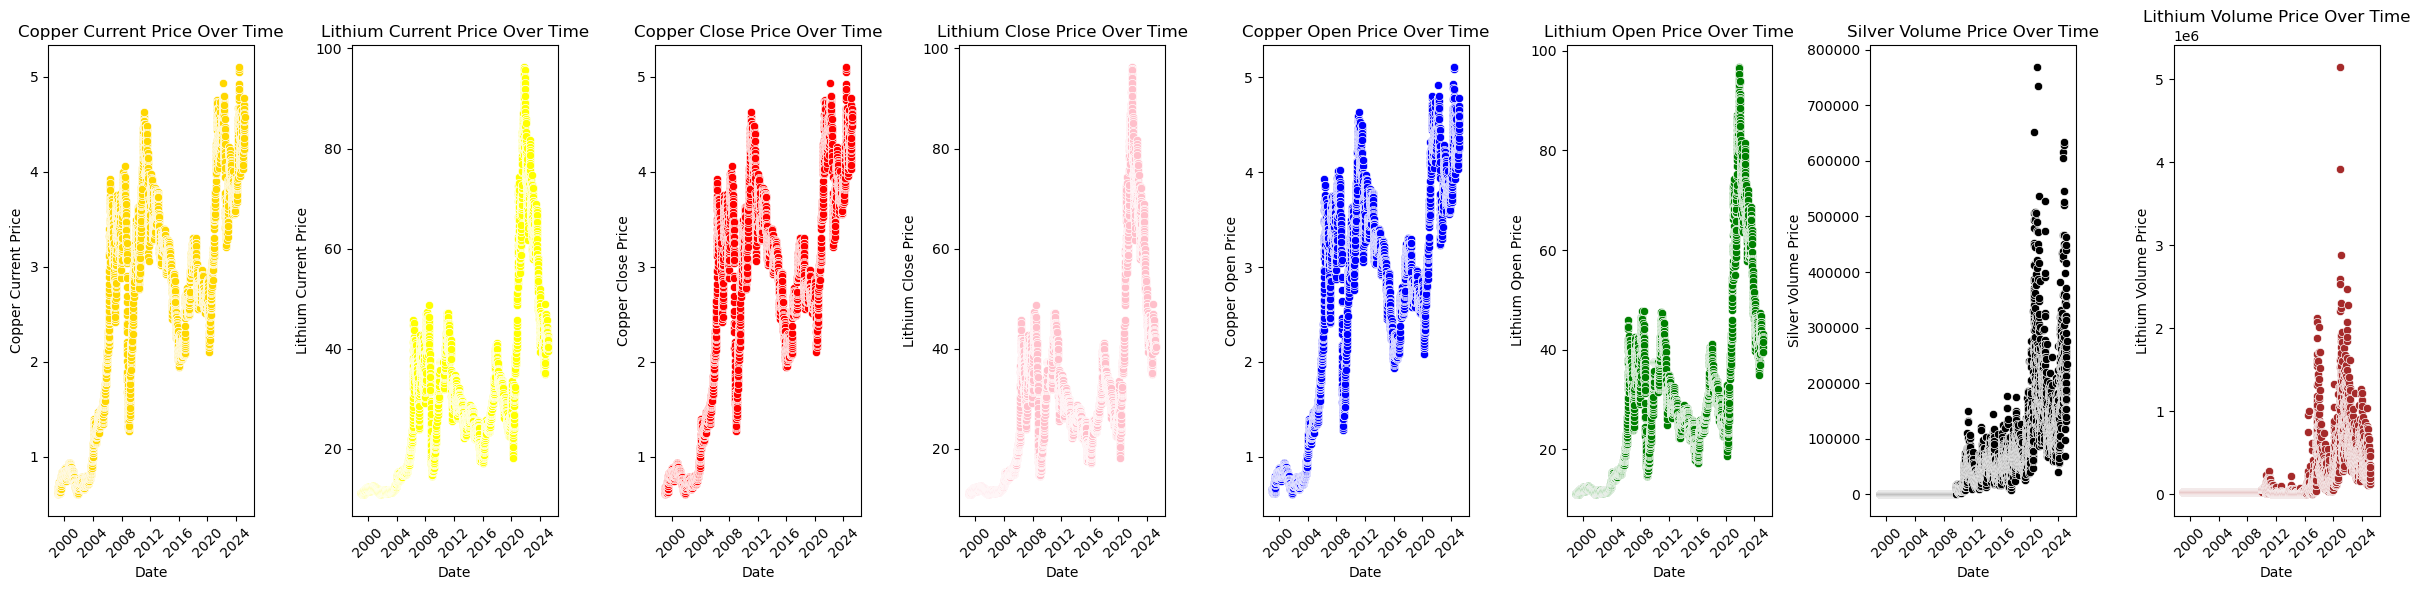

In [34]:
# Create figure and axes for two subplots side by side
fig, axes = plt.subplots(1, 8, figsize=(24, 6), sharex=True)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# First scatter plot: Gold price
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Copper_price'], ax=axes[0], color='gold')
axes[0].set_title('Copper Current Price Over Time')
axes[0].set_ylabel('Copper Current Price')

# Second scatter plot: Lithium price
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Lithium_price'], ax=axes[1], color='yellow')
axes[1].set_title('Lithium Current Price Over Time')
axes[1].set_ylabel('Lithium Current Price')

# third scatter plot: Copper_close
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Copper_close'], ax=axes[2], color='red')
axes[2].set_title('Copper Close Price Over Time')
axes[2].set_ylabel('Copper Close Price')

# fourth scatter plot: Lithium close
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Lithium_close'], ax=axes[3], color='pink')
axes[3].set_title('Lithium Close Price Over Time')
axes[3].set_ylabel('Lithium Close Price')

# fifth scatter plot: Copper_open
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Copper_open'], ax=axes[4], color='blue')
axes[4].set_title('Copper Open Price Over Time')
axes[4].set_ylabel('Copper Open Price')

# Sixth scatter plot: Lithium open
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Lithium_open'], ax=axes[5], color='green')
axes[5].set_title('Lithium Open Price Over Time')
axes[5].set_ylabel('Lithium Open Price')

# Seventh scatter plot: Copper_open
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Silver_volume'], ax=axes[6], color='black')
axes[6].set_title('Silver Volume Price Over Time')
axes[6].set_ylabel('Silver Volume Price')

# Eighth scatter plot: Lithium open
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Lithium_volume'], ax=axes[7], color='brown')
axes[7].set_title('Lithium Volume Price Over Time')
axes[7].set_ylabel('Lithium Volume Price')

# Rotate x-axis labels for better readability
for ax in axes:
    ax.set_xlabel('Date')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()  
plt.show()

In [35]:
aapl_data.drop(columns='pe_log', inplace=True)

percent_missing(aapl_data)

Series([], dtype: float64)

In [36]:
aapl_data.isnull().sum()

date                                      0
AAPL_close                                0
AAPL_high                                 0
AAPL_low                                  0
AAPL_open                                 0
AAPL_traded_volume                        0
AAPL_adjClose                             0
AAPL_adjLow                               0
AAPL_adjOpen                              0
AAPL_adj_traded_volume                    0
AAPL_divCash                              0
AAPL_splitFactor                          0
pe                                        0
communicationServicesChangesPercentage    0
consumerCyclicalChangesPercentage         0
consumerDefensiveChangesPercentage        0
energyChangesPercentage                   0
healthcareChangesPercentage               0
industrialsChangesPercentage              0
realEstateChangesPercentage               0
technologyChangesPercentage               0
utilitiesChangesPercentage                0
month1                          

In [37]:
# creating a separate copy for other models that do not require creating lagged features
separate_aapl_data = aapl_data.copy()

In [38]:
aapl_data.sample(8).sort_values('date')

,date,AAPL_close,AAPL_high,AAPL_low,AAPL_open,AAPL_traded_volume,AAPL_adjClose,AAPL_adjLow,AAPL_adjOpen,AAPL_adj_traded_volume,AAPL_divCash,AAPL_splitFactor,pe,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,AAPL_stock_news_sentiment,AAPL_press_release_sentiment,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,NVDA_stock_news_sentiment,NVDA_press_release_sentiment,month,year,season
4904,2000-03-21,134.940000,136.750000,121.620000,122.560000,4681500,1.015115,0.914912,0.921983,524328524,0.000000,1.000000,113.381086,0.163980,7.036610,1.968810,4.621410,-0.111480,1.497380,0.958220,0.014120,-0.678090,0.960000,5.910000,6.130000,6.220000,6.500000,6.480000,6.440000,6.390000,6.130000,6.280000,5.970000,2.190000,655.000000,199.000000,680.000000,655.000000,0.818500,9577.000000,0.806000,0.818500,11.988825,29792.528909,11.953928,11.988825,5.115000,0.000000,5.050000,5.115000,289.630000,0.000000,286.250000,289.630000,1.200000,100.000000,1.200000,1.200000,100.000000,0.000000,1.200000,-15.384615,1.200000,weakly_negative,neutral,94.880000,100.900000,87.000000,100.000000,1118000.000000,0.181297,0.166239,0.191080,536639731.000000,0.000000,1.000000,neutral,neutral,3,2000,Spring
5112,2001-01-08,16.560000,16.980000,15.940000,16.940000,6673200,0.249152,0.239824,0.254869,373699573,0.000000,1.000000,49.517789,-3.358920,0.955630,1.448260,0.868510,-2.570910,1.057660,0.607560,-32.815000,2.037950,2.300000,5.190000,5.030000,4.610000,4.540000,4.550000,4.650000,4.940000,4.940000,5.520000,5.420000,2.190000,1025.600000,72.000000,998.900000,1025.600000,0.828500,7509.000000,0.824000,0.828500,12.040715,29792.528909,12.047056,12.040715,4.570000,0.000000,4.570000,4.570000,268.350000,0.000000,268.400000,268.350000,0.295760,100.000000,0.295760,0.295760,100.000000,0.000000,0.295760,-40.288925,0.295760,neutral,neutral,40.630000,42.250000,36.060000,36.060000,2390700.000000,0.155271,0.137807,0.137807,573767713.000000,0.000000,1.000000,weakly_negative,neutral,1,2001,Winter
5577,2002-10-25,15.420000,15.450000,14.590000,14.690000,4983400,0.232000,0.219513,0.221017,279070679,0.000000,1.000000,394.047099,1.329150,2.386470,-0.561160,-2.221600,3.087900,2.002900,1.340480,-0.000310,4.230450,1.630000,1.640000,1.620000,1.690000,1.980000,2.350000,3.100000,3.690000,4.120000,5.160000,5.400000,2.190000,311.400000,136.000000,310.500000,311.400000,0.714500,13777.000000,0.699000,0.714500,11.462252,29792.528909,11.415004,11.462252,4.412000,0.000000,4.380000,4.412000,313.850000,0.000000,311.650000,313.850000,0.275360,100.000000,0.275360,0.275360,100.000000,0.000000,0.275360,-3.452769,0.275360,neutral,neutral,11.100000,11.150000,10.360000,10.500000,6216300.000000,0.084839,0.079183,0.080254,745955627.000000,0.000000,1.000000,neutral,neutral,10,2002,Fall
7642,2010-10-05,288.940000,289.450000,281.820000,282.000000,17927400,8.694448,8.480201,8.485617,501967701,0.000000,1.000000,7.167899,1.717950,-1.353030,1.298380,1.839270,2.833260,7.037830,1.821660,1.040270,0.757400,0.140000,0.120000,0.180000,0.250000,0.410000,0.600000,1.210000,1.830000,2.500000,3.410000,3.740000,1.850000,578.200000,2139.000000,560.500000,578.200000,3.726500,29032.000000,3.666000,3.726500,37.560000,49600.000000,37.400000,37.560000,22.825000,13134.000000,21.938000,22.825000,1340.600000,26445.000000,1315.12000

In [39]:
def created_lagged_features_daily(data, target_col, external_features, max_lag=30):
    df = data.copy()

    # lag target feature (stock price) from 1 to 7 days
    # for lag in range(1, 8):
    for lag in range(1, max_lag + 1):
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)

    # Selectively lagging external features with specific lags
    for feature in external_features:
        if feature == 'inflationRate':
            # attempting to capture long-term dependency with max lags
            for lag in range(1, max_lag + 1):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

        elif feature == 'Gold_price':
            # lagging short-term dependencies
            # for lag in range(1, 8):
            for lag in range(1, max_lag + 1):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
        
        elif feature == 'Silver_price':
            # lagging short-term dependencies
            # for lag in range(1, 8):
            for lag in range(1, max_lag + 1):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

        elif feature == 'AAPL_stock_news_sentiment':
            # lagging very short-term dependencies for news sentiments as news trends change often
            # for lag in range(1, 6):
            for lag in range(1, max_lag + 1):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

        elif feature == 'NVDA_stock_news_sentiment':
            # lagging short-term dependencies for press releases
            # for lag in range(1, 8):
            for lag in range(1, max_lag + 1):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    
    df.dropna(inplace=True) # dropping all NaN values after shifting
    
    return df

In [40]:
external_features = [ 'Silver_price', 'inflationRate', 'NVDA_stock_news_sentiment', 'Gold_price', 'AAPL_stock_news_sentiment']

aapl_data = created_lagged_features_daily(aapl_data, 'AAPL_close', external_features=external_features)

aapl_data['day'] = aapl_data['date'].dt.day

aapl_data.head()

C:\Users\ekf98\AppData\Local\Temp\ipykernel_29148\454181893.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
C:\Users\ekf98\AppData\Local\Temp\ipykernel_29148\454181893.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
C:\Users\ekf98\AppData\Local\Temp\ipykernel_29148\454181893.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

,date,AAPL_close,AAPL_high,AAPL_low,AAPL_open,AAPL_traded_volume,AAPL_adjClose,AAPL_adjLow,AAPL_adjOpen,AAPL_adj_traded_volume,AAPL_divCash,AAPL_splitFactor,pe,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,AAPL_stock_news_sentiment,AAPL_press_release_sentiment,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,NVDA_stock_news_sentiment,NVDA_press_release_sentiment,month,year,season,AAPL_close_lag_1,AAPL_close_lag_2,AAPL_close_lag_3,AAPL_close_lag_4,AAPL_close_lag_5,AAPL_close_lag_6,AAPL_close_lag_7,AAPL_close_lag_8,AAPL_close_lag_9,AAPL_close_lag_10,AAPL_close_lag_11,AAPL_close_lag_12,AAPL_close_lag_13,AAPL_close_lag_14,AAPL_close_lag_15,AAPL_close_lag_16,AAPL_close_lag_17,AAPL_close_lag_18,AAPL_close_lag_19,AAPL_close_lag_20,AAPL_close_lag_21,AAPL_close_lag_22,AAPL_close_lag_23,AAPL_close_lag_24,AAPL_close_lag_25,AAPL_close_lag_26,AAPL_close_lag_27,AAPL_close_lag_28,AAPL_close_lag_29,AAPL_close_lag_30,Silver_price_lag_1,Silver_price_lag_2,Silver_price_lag_3,Silver_price_lag_4,Silver_price_lag_5,Silver_price_lag_6,Silver_price_lag_7,Silver_price_lag_8,Silver_price_lag_9,Silver_price_lag_10,Silver_price_lag_11,Silver_price_lag_12,Silver_price_lag_13,Silver_price_lag_14,Silver_price_lag_15,Silver_price_lag_16,Silver_price_lag_17,Silver_price_lag_18,Silver_price_lag_19,Silver_price_lag_20,Silver_price_lag_21,Silver_price_lag_22,Silver_price_lag_23,Silver_price_lag_24,Silver_price_lag_25,Silver_price_lag_26,Silver_price_lag_27,Silver_price_lag_28,Silver_price_lag_29,Silver_price_lag_30,inflationRate_lag_1,inflationRate_lag_2,inflationRate_lag_3,inflationRate_lag_4,inflationRate_lag_5,inflationRate_lag_6,inflationRate_lag_7,inflationRate_lag_8,inflationRate_lag_9,inflationRate_lag_10,inflationRate_lag_11,inflationRate_lag_12,inflationRate_lag_13,inflationRate_lag_14,inflationRate_lag_15,inflationRate_lag_16,inflationRate_lag_17,inflationRate_lag_18,inflationRate_lag_19,inflationRate_lag_20,inflationRate_lag_21,inflationRate_lag_22,inflationRate_lag_23,inflationRate_lag_24,inflationRate_lag_25,inflationRate_lag_26,inflationRate_lag_27,inflationRate_lag_28,inflationRate_lag_29,inflationRate_lag_30,NVDA_stock_news_sentiment_lag_1,NVDA_stock_news_sentiment_lag_2,NVDA_stock_news_sentiment_lag_3,NVDA_stock_news_sentiment_lag_4,NVDA_stock_news_sentiment_lag_5,NVDA_stock_news_sentiment_lag_6,NVDA_stock_news_sentiment_lag_7,NVDA_stock_news_sentiment_lag_8,NVDA_stock_news_sentiment_lag_9,NVDA_stock_news_sentiment_lag_10,NVDA_stock_news_sentiment_lag_11,NVDA_stock_news_sentiment_lag_12,NVDA_stock_news_sentiment_lag_13,NVDA_stock_news_sentiment_lag_14,NVDA_stock_news_sentiment_lag_15,NVDA_stock_news_sentiment_lag_16,NVDA_stock_news_sentiment_lag_17,NVDA_stock_news_sentiment_lag_18,NVDA_stock_news_sentiment_lag_19,NVDA_stock_news_sentiment_lag_20,NVDA_stock_news_sentiment_lag_21,NVDA_stock_news_sentiment_lag_22,NVDA_stock_news_sentiment_lag_23,NVDA_stock_news_sentiment_lag_24,NVDA_stock_news_sentiment_lag_25,NVDA_stock_news_sentiment_lag_26,NVDA_stock_news_sentiment_lag_27,NVDA_stock_news_sentiment_lag_28,NVDA_stock_news_sentiment_lag_29,NVDA_stock_news_sentiment_lag_30,Gold_price_lag_1,Gold_price_lag_2,Gold_price_lag_3,Gold_price_lag_4,Gold_price_lag_5,Gold_price_lag_6,Gold_price_lag_7,Gold_price_lag_8,Gold_price_lag_9,G

In [41]:
aapl_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6637 entries, 4632 to 11383
Columns: 262 entries, date to day
dtypes: datetime64[ns](1), float64(191), int32(3), int64(2), object(65)
memory usage: 13.2+ MB


In [ ]:
# Obtainig Dummies
aapl_data = pd.get_dummies(aapl_data, drop_first=True)

num_cols = list(aapl_data.select_dtypes(include=['float64', 'int64', 'int32']).columns)

num_cols.remove('AAPL_close')

print(num_cols)

print(len(num_cols), len(aapl_data.columns))

['AAPL_high', 'AAPL_low', 'AAPL_open', 'AAPL_traded_volume', 'AAPL_adjClose', 'AAPL_adjLow', 'AAPL_adjOpen', 'AAPL_adj_traded_volume', 'AAPL_divCash', 'AAPL_splitFactor', 'pe', 'communicationServicesChangesPercentage', 'consumerCyclicalChangesPercentage', 'consumerDefensiveChangesPercentage', 'energyChangesPercentage', 'healthcareChangesPercentage', 'industrialsChangesPercentage', 'realEstateChangesPercentage', 'technologyChangesPercentage', 'utilitiesChangesPercentage', 'month1', 'month3', 'month6', 'year1', 'year2', 'year3', 'year5', 'year7', 'year10', 'year20', 'year30', 'inflationRate', 'Palladium_price', 'Palladium_volume', 'Palladium_open', 'Palladium_close', 'Copper_price', 'Copper_volume', 'Copper_open', 'Copper_close', 'Lithium_price', 'Lithium_volume', 'Lithium_open', 'Lithium_close', 'Silver_price', 'Silver_volume', 'Silver_open', 'Silver_close', 'Gold_price', 'Gold_volume', 'Gold_open', 'Gold_close', 'sma', 'adx', 'dema', 'ema', 'rsi', 'standardDeviation', 'tema', 'williams

In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))


aapl_data[num_cols] = scaler.fit_transform(aapl_data[num_cols])

aapl_data.head()

,date,AAPL_close,AAPL_high,AAPL_low,AAPL_open,AAPL_traded_volume,AAPL_adjClose,AAPL_adjLow,AAPL_adjOpen,AAPL_adj_traded_volume,AAPL_divCash,AAPL_splitFactor,pe,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,month,year,AAPL_close_lag_1,AAPL_close_lag_2,AAPL_close_lag_3,AAPL_close_lag_4,AAPL_close_lag_5,AAPL_close_lag_6,AAPL_close_lag_7,AAPL_close_lag_8,AAPL_close_lag_9,AAPL_close_lag_10,AAPL_close_lag_11,AAPL_close_lag_12,AAPL_close_lag_13,AAPL_close_lag_14,AAPL_close_lag_15,AAPL_close_lag_16,AAPL_close_lag_17,AAPL_close_lag_18,AAPL_close_lag_19,AAPL_close_lag_20,AAPL_close_lag_21,AAPL_close_lag_22,AAPL_close_lag_23,AAPL_close_lag_24,AAPL_close_lag_25,AAPL_close_lag_26,AAPL_close_lag_27,AAPL_close_lag_28,AAPL_close_lag_29,AAPL_close_lag_30,Silver_price_lag_1,Silver_price_lag_2,Silver_price_lag_3,Silver_price_lag_4,Silver_price_lag_5,Silver_price_lag_6,Silver_price_lag_7,Silver_price_lag_8,Silver_price_lag_9,Silver_price_lag_10,Silver_price_lag_11,Silver_price_lag_12,Silver_price_lag_13,Silver_price_lag_14,Silver_price_lag_15,Silver_price_lag_16,Silver_price_lag_17,Silver_price_lag_18,Silver_price_lag_19,Silver_price_lag_20,Silver_price_lag_21,Silver_price_lag_22,Silver_price_lag_23,Silver_price_lag_24,Silver_price_lag_25,Silver_price_lag_26,Silver_price_lag_27,Silver_price_lag_28,Silver_price_lag_29,Silver_price_lag_30,inflationRate_lag_1,inflationRate_lag_2,inflationRate_lag_3,inflationRate_lag_4,inflationRate_lag_5,inflationRate_lag_6,inflationRate_lag_7,inflationRate_lag_8,inflationRate_lag_9,inflationRate_lag_10,inflationRate_lag_11,inflationRate_lag_12,inflationRate_lag_13,inflationRate_lag_14,inflationRate_lag_15,inflationRate_lag_16,inflationRate_lag_17,inflationRate_lag_18,inflationRate_lag_19,inflationRate_lag_20,inflationRate_lag_21,inflationRate_lag_22,inflationRate_lag_23,inflationRate_lag_24,inflationRate_lag_25,inflationRate_lag_26,inflationRate_lag_27,inflationRate_lag_28,inflationRate_lag_29,inflationRate_lag_30,Gold_price_lag_1,Gold_price_lag_2,Gold_price_lag_3,Gold_price_lag_4,Gold_price_lag_5,Gold_price_lag_6,Gold_price_lag_7,Gold_price_lag_8,Gold_price_lag_9,Gold_price_lag_10,Gold_price_lag_11,Gold_price_lag_12,Gold_price_lag_13,Gold_price_lag_14,Gold_price_lag_15,Gold_price_lag_16,Gold_price_lag_17,Gold_price_lag_18,Gold_price_lag_19,Gold_price_lag_20,Gold_price_lag_21,Gold_price_lag_22,Gold_price_lag_23,Gold_price_lag_24,Gold_price_lag_25,Gold_price_lag_26,Gold_price_lag_27,Gold_price_lag_28,Gold_price_lag_29,Gold_price_lag_30,day,AAPL_stock_news_sentiment_strongly_negative,AAPL_stock_news_sentiment_strongly_positive,AAPL_stock_news_sentiment_weakly_negative,AAPL_stock_news_sentiment_weakly_positive,AAPL_press_release_sentiment_strongly_negative,AAPL_press_release_sentiment_strongly_positive,AAPL_press_release_sentiment_weakly_negative,AAPL_press_release_sentiment_weakly_positive,NVDA_stock_news_sentiment_strongly_negative,NVDA_stock_news_sentiment_strongly_positive,NVDA_stock_news_sentiment_weakly_negative,NVDA_stock_news_sentiment_weakly_positive,NVDA_press_release_sentiment_strongly_negative,NVDA_press_release_sentiment_strongly_positive,NVDA_press_release_sentiment_weakly_negative,NVDA_press_release_sentiment_weakly_positive,seaso

In [44]:
aapl_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6637 entries, 4632 to 11383
Columns: 456 entries, date to AAPL_stock_news_sentiment_lag_30_weakly_positive
dtypes: bool(259), datetime64[ns](1), float64(196)
memory usage: 11.7 MB


# Lasso (Baseline) Model For Apple

In [45]:
# Step 2: Split the data based on a date threshold ( using the 80th percentile of dates as the split point)
split_date = aapl_data['date'].quantile(0.8) 
train_data = aapl_data[aapl_data['date'] <= split_date]
test_data = aapl_data[aapl_data['date'] > split_date]


# creating response and predictor features
X = train_data.drop(columns=["AAPL_close"]) 
y = train_data["AAPL_close"]

x_test = test_data.drop(columns=['AAPL_close'])
y_test = test_data['AAPL_close']

In [46]:
# Creating folds for cross-validation to determine optimum Lasso
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)

# Creating unix timestamps of date column as lasso requires that to process the 'date' column
X["date"] = X["date"].astype('int64') // 10**9  # Converts to Unix timestamp (seconds)

# Setting up cross-validated Lasso Model
lassoCV = LassoCV(alphas=np.logspace(-5, 2, 150), # Creating range of alphas from 0.00001 to 10000 for 180 evenly spaced samples  
                  cv=kfold,
                  random_state=1,
                  max_iter= 50000,
                  n_jobs=-1)

# Fitting a lasso model on training X and Y values
tuned_lasso = lassoCV.fit(X,y)

# Displaying the optimum Lasso the minimizes the Root mean squared error
print(f"Optimum Lasso: {tuned_lasso.alpha_}")

# Obtaining the Training RMSE obtained from the optimum lasso
validation_mse = np.min(tuned_lasso.mse_path_.mean(1))
print(f'Validation RMSE: {np.sqrt(validation_mse)}')

Optimum Lasso: 0.01260872407680681
Validation RMSE: 1.3189713766233133


In [47]:
final_lasso = Lasso(alpha=tuned_lasso.alpha_, max_iter=25000)

final_lasso.fit(X, y)

x_test["date"] = x_test["date"].astype('int64') // 10**9  # Converts to Unix timestamp (seconds)

y_pred = final_lasso.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test RMSE: {rmse}")

Test RMSE: 1.0928618280012683


c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.092e+04, tolerance: 1.338e+04
  model = cd_fast.enet_coordinate_descent(


Validation RMSE: 1.9213695340801884
Validation RMSE: 3.0805650788327914
Validation RMSE: 4.665408251557364


c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.436e+04, tolerance: 8.890e+03
  model = cd_fast.enet_coordinate_descent(


Validation RMSE: 1.395629024552142


c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.301e+04, tolerance: 1.325e+04
  model = cd_fast.enet_coordinate_descent(


Validation RMSE: 0.6798368811936567


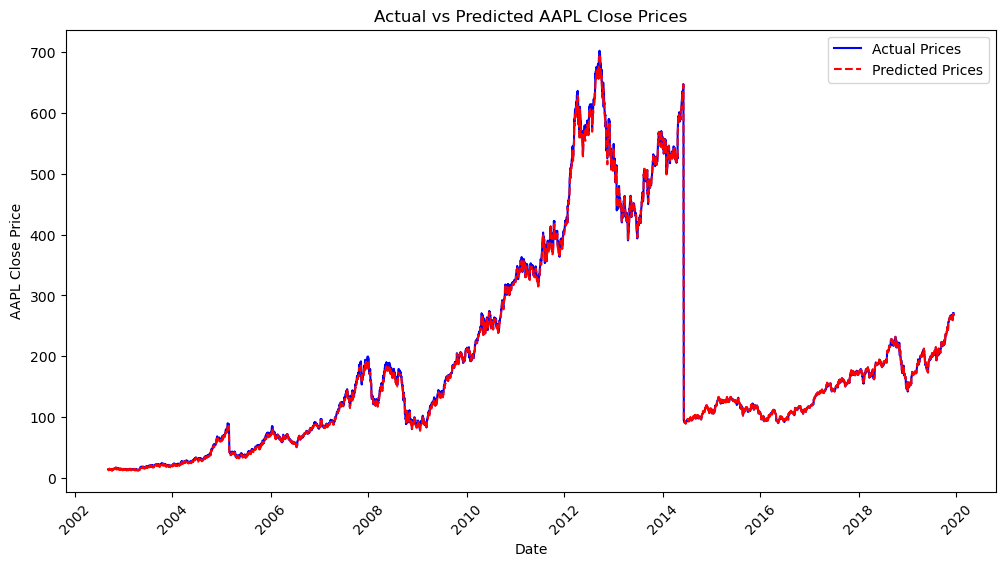

In [48]:
# timeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=K)

# Store actual and predicted values
all_dates = []
all_actuals = []
all_preds = []


final_lasso = Lasso(alpha=tuned_lasso.alpha_, max_iter=25000)

X['date'] = train_data['date']

X["date"] = X["date"].astype('int64') // 10**9  # Converts to Unix timestamp (seconds)

# cross-validation loop
for train, valid in tscv.split(X):
    x_train, x_valid = X.iloc[train], X.iloc[valid]
    y_train, y_valid = y.iloc[train], y.iloc[valid]

    
    final_lasso.fit(x_train, y_train)
    y_pred = final_lasso.predict(x_valid)

    # Collect results
    all_dates.extend(x_valid['date'])
    all_actuals.extend(y_valid)
    all_preds.extend(y_pred)

    # Calculating performance
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(f'Validation RMSE: {rmse}')

# Create DataFrame for plotting
results_df = pd.DataFrame({'Date': all_dates, 'Actual': all_actuals, 'Predicted': all_preds})

results_df['Date'] = pd.to_datetime(results_df['Date'], unit='s')

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='Date', y='Actual', label='Actual Prices', color='blue')
sns.lineplot(data=results_df, x='Date', y='Predicted', label='Predicted Prices', color='red', linestyle='dashed')

plt.xlabel("Date")
plt.ylabel("AAPL Close Price")
plt.title("Actual vs Predicted AAPL Close Prices")
plt.legend()
plt.xticks(rotation=45)
plt.show()

c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.092e+04, tolerance: 1.338e+04
  model = cd_fast.enet_coordinate_descent(


Test RMSE: 1.0928618280012683


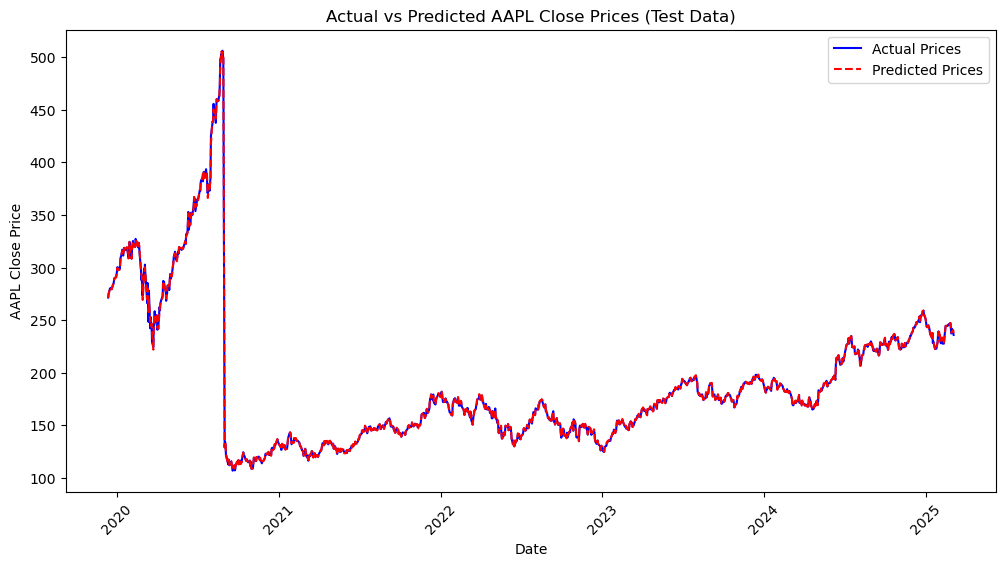

c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with featu

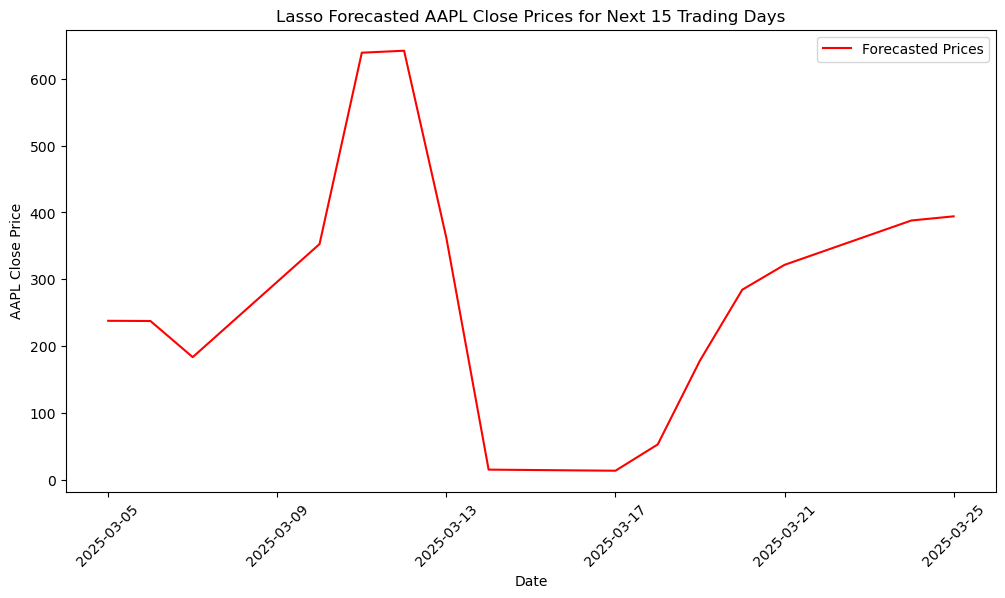

In [49]:
x_test = test_data.drop(columns=['AAPL_close'])
x_test["date"] = x_test["date"].astype('int64') // 10**9  # Converts to Unix timestamp (seconds)

y_test = test_data['AAPL_close']


final_lasso.fit(X, y)
y_pred = final_lasso.predict(x_test)


# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: {rmse}')

x_test['date'] = pd.to_datetime(x_test['date'], unit='s')

# Create DataFrame for test data results
test_results_df = pd.DataFrame({'Date': x_test['date'], 'Actual': y_test, 'Predicted': y_pred})

# Plot actual vs. predicted prices for test data
plt.figure(figsize=(12, 6))
sns.lineplot(data=test_results_df, x='Date', y='Actual', label='Actual Prices', color='blue')
sns.lineplot(data=test_results_df, x='Date', y='Predicted', label='Predicted Prices', color='red', linestyle='dashed')

plt.xlabel("Date")
plt.ylabel("AAPL Close Price")
plt.title("Actual vs Predicted AAPL Close Prices (Test Data)")
plt.legend()
plt.xticks(rotation=45)
plt.show()



#################### ----------------------------------------------------------- ##############
# Generating Forecast for the Next 3 Weeks (21 days)

# Convert 'date' to datetime before finding the max date
x_test['date'] = pd.to_datetime(x_test['date'])

# Find the last date in the dataset
last_date = x_test['date'].max()

# Create a new date range for the next 21 days
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=21, freq='B')


# Initialize the forecast list
forecast_lasso = []

# Use the entire x_test data for the first prediction
last_known_data = x_test.values

for _ in range(15):  # Forecasting for the next 15 trading days
    # Convert Timestamp to numeric (Unix timestamp) if necessary
    if isinstance(last_known_data[0, 0], pd.Timestamp):
        last_known_data[:, 0] = np.array([t.timestamp() for t in last_known_data[:, 0]])

     # Ensure data is float type
    last_known_data = last_known_data.astype(float)

    # Predict the next value using the entire dataset
    pred = final_lasso.predict(last_known_data)[-1]  # Use the last prediction from the model's output
    pred = max(pred, 0)  # Ensure the prediction is not negative
    forecast_lasso.append(pred)
    
    # Append the new prediction to the last_known_data
    new_row = np.roll(last_known_data[-1], -1)  # Shift the last row
    new_row[-1] = pred  # Add the new prediction to the last position
    last_known_data = np.vstack([last_known_data, new_row])  # Append the new row to the dataset

# Create a DataFrame for future dates
future_df = pd.DataFrame({'date': future_dates[:15],  # Assuming future_dates has at least 15 dates
                          'forecasted_prices': forecast_lasso})


# Plot forecasted prices
plt.figure(figsize=(12, 6))
sns.lineplot(data=future_df, x='date', y='forecasted_prices', label='Forecasted Prices', color='red')

plt.xlabel("Date")
plt.ylabel("AAPL Close Price")
plt.title("Lasso Forecasted AAPL Close Prices for Next 15 Trading Days")
plt.legend()
plt.xticks(rotation=45)
plt.show()

          date  forecasted_prices  AAPL_close
0  2025-03-05         237.818949  235.740000
1  2025-03-06         237.507550  235.330000
2  2025-03-07         183.457140  239.070000
3  2025-03-10         352.615290  227.480000
4  2025-03-11         638.941985  220.840000
5  2025-03-12         641.899319  216.980000
6  2025-03-13         361.820533  209.680000
7  2025-03-14          15.141462  213.490000
8  2025-03-17          13.499224  214.000000
9  2025-03-18          52.816461  212.690000
10 2025-03-19         178.409359  215.240000
11 2025-03-20         284.335332  214.100000
12 2025-03-21         321.519453  218.270000
13 2025-03-24         387.893309  220.730000
14 2025-03-25         394.107721  223.750000 

Pearson Correlation between forecasted prices and actual prices: 0.06068139835242481  with a p-value of: 0.8299030408275637 
 Spearman Correlation between forecasted prices and actual prices: 0.25  with a p-value of: 0.36884629178393047 
 Forecasted Root Mean Squared Error: 19

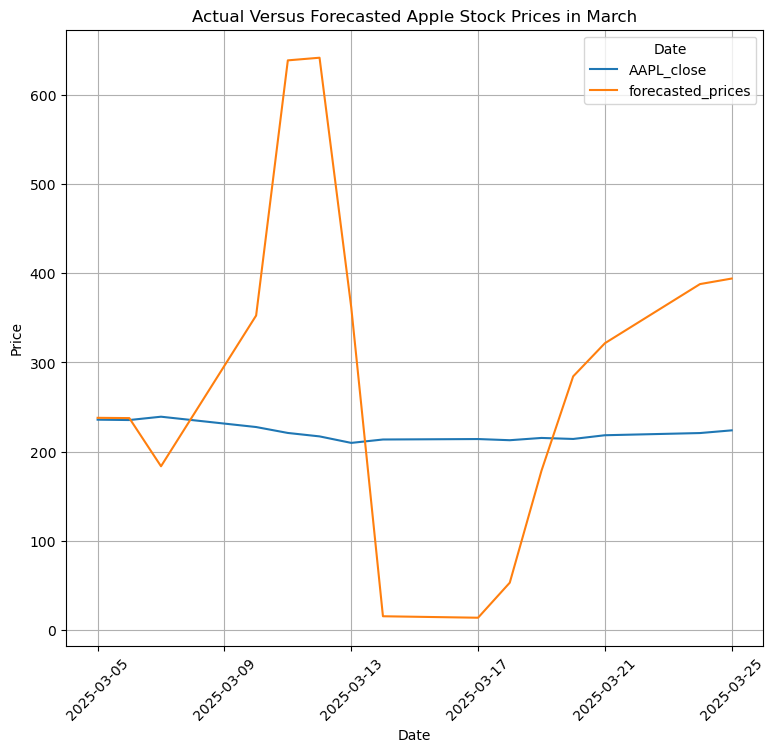

In [50]:
apple_march_prices = pd.read_csv("march_prices/AAPL_march_prices.csv")


apple_lasso = pd.concat([future_df, apple_march_prices['AAPL_close']], axis=1)

print(f" {apple_lasso} \n")

# Assuming you have two columns: 'forecasted_prices' and 'AAPL_close'
correlation, p_value = pearsonr(apple_lasso['forecasted_prices'], apple_lasso['AAPL_close'])

# Calculate Spearman's correlation
spearman_corr, p_value_spear = spearmanr(apple_lasso['forecasted_prices'], apple_lasso['AAPL_close'])


# Calculate Pearson correlation
correlation = apple_lasso[['forecasted_prices', 'AAPL_close']].corr().iloc[0, 1]


rmse = np.sqrt(np.mean((apple_lasso['AAPL_close'] - apple_lasso['forecasted_prices'])**2)) # for our given stock price ranges, rmse between 5-10 is good but the lower the better

mae = np.mean(np.abs((apple_lasso['AAPL_close'] - apple_lasso['forecasted_prices']))) # similarly for mae, the lower the better

mape = np.mean(np.abs((apple_lasso['AAPL_close'] - apple_lasso['forecasted_prices']) / apple_lasso['AAPL_close'])) * 100 # aim for mape below 10% if possible


# Prioritising correlation overall is key. Hopefully the ARIMA model beats this correlation and improves the other metrics as well

print(f"Pearson Correlation between forecasted prices and actual prices: {correlation}  with a p-value of: {p_value} \n",
      f"Spearman Correlation between forecasted prices and actual prices: {spearman_corr}  with a p-value of: {p_value_spear} \n", 
       
      f"Forecasted Root Mean Squared Error: {rmse} \n",
      f"Forecasted Mean Absolute Error: {mae} \n",
      f"Mean Absolute Percentage Error: {mape} \n")

# reshaping data for plotting in seaborn
apple_melted = apple_lasso.melt(id_vars=['date'],
                               value_vars=['AAPL_close', 'forecasted_prices'],
                               var_name='Date',
                               value_name='Price')

# Plotting in Seaborn
plt.figure(figsize=(9, 8))
sns.lineplot(data=apple_melted, x='date', y='Price', hue='Date', markers='o')

# labels
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual Versus Forecasted Apple Stock Prices in March')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

# Sequential LSTM Model for Apple 

In [51]:
separate_aapl_data.head()

,date,AAPL_close,AAPL_high,AAPL_low,AAPL_open,AAPL_traded_volume,AAPL_adjClose,AAPL_adjLow,AAPL_adjOpen,AAPL_adj_traded_volume,AAPL_divCash,AAPL_splitFactor,pe,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,AAPL_stock_news_sentiment,AAPL_press_release_sentiment,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,NVDA_stock_news_sentiment,NVDA_press_release_sentiment,month,year,season
4602,1999-01-22,38.750000,39.500000,37.060000,37.690000,3087200,0.291505,0.278792,0.283531,345766745,0.000000,1.000000,82.589343,0.853720,-0.307020,-0.737890,-0.311530,0.781540,0.297280,0.386630,-0.000910,-0.082430,0.960000,4.360000,4.440000,4.460000,4.590000,4.580000,4.540000,4.730000,4.640000,5.380000,5.090000,2.190000,321.050000,38.000000,320.000000,321.050000,0.657000,6178.000000,0.658500,0.657000,11.181112,29792.528909,11.217418,11.181112,5.115000,0.000000,5.115000,5.115000,286.450000,0.000000,287.450000,286.450000,0.345980,100.000000,0.345980,0.345980,0.000000,0.000000,0.345980,-30.790441,0.345980,neutral,weakly_positive,19.690000,23.440000,18.630000,21.000000,5655600.000000,0.037624,0.035598,0.040127,2714686642.000000,0.000000,1.000000,neutral,neutral,1,1999,Winter
4603,1999-01-25,39.380000,39.560000,38.810000,39.250000,3440500,0.296244,0.291956,0.295266,385336385,0.000000,1.000000,82.589343,0.853720,-0.307020,-0.737890,-0.311530,0.781540,0.297280,0.386630,-0.000910,-0.082430,0.960000,4.440000,4.450000,4.480000,4.590000,4.580000,4.550000,4.740000,4.670000,5.400000,5.120000,2.190000,325.000000,127.000000,321.050000,325.000000,0.653500,5340.000000,0.652000,0.653500,11.164224,29792.528909,11.186026,11.164224,5.185000,0.000000,5.100000,5.185000,287.850000,0.000000,286.450000,287.850000,0.351560,100.000000,0.351560,0.351560,100.000000,0.000000,0.351560,-25.074627,0.351560,neutral,neutral,21.750000,22.000000,19.690000,21.250000,1063500.000000,0.041560,0.037624,0.040604,510479744.000000,0.000000,1.000000,neutral,neutral,1,1999,Winter
4604,1999-01-26,40.500000,40.880000,39.630000,39.940000,5000400,0.304670,0.298125,0.300457,560045360,0.000000,1.000000,82.589343,0.853720,-0.307020,-0.737890,-0.311530,0.781540,0.297280,0.386630,-0.000910,-0.082430,0.960000,4.460000,4.460000,4.510000,4.630000,4.610000,4.580000,4.760000,4.690000,5.410000,5.120000,2.190000,326.750000,27.000000,325.500000,326.750000,0.649500,7328.000000,0.654000,0.649500,11.144954,29792.528909,11.195676,11.144954,5.115000,0.000000,5.175000,5.115000,286.150000,0.000000,287.750000,286.150000,0.361610,100.000000,0.361610,0.361610,100.000000,0.000000,0.361610,-29.991047,0.361610,neutral,neutral,20.060000,22.440000,19.750000,22.000000,715000.000000,0.038331,0.037738,0.042038,343199828.000000,0.000000,1.000000,neutral,neutral,1,1999,Winter
4605,1999-01-27,40.130000,41.380000,39.940000,41.000000,3258500,0.301886,0.300457,0.308431,364952364,0.000000,1.000000,82.589343,0.853720,-0.307020,-0.737890,-0.311530,0.781540,0.297280,0.386630,-0.000910,-0.082430,0.960000,4.470000,4.470000,4.510000,4.570000,4.570000,4.570000,4.740000,4.680000,5.400000,5.140000,2.190000,329.000000,63.000000,329.000000,329.000000,0.644000,3401.000000,0.643000,0.644000,11.118512,29792.528909,11.142707,11.118512,5.095000,0.000000,5.115000,5.095000,283.000000,0.000000,285.950000,283.000000,0.358260,100.0000

In [52]:
# Remove columns where the column name contains 'NVDA'
s_appl = separate_aapl_data.loc[:, ~separate_aapl_data.columns.str.contains('NVDA')]

s_appl['date'] = pd.to_datetime(s_appl['date'])

s_appl['date_unix'] = s_appl['date'].astype('int64') // 10**9

# Print the cleaned data
s_appl.head()

C:\Users\ekf98\AppData\Local\Temp\ipykernel_29148\924940517.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_appl['date'] = pd.to_datetime(s_appl['date'])
C:\Users\ekf98\AppData\Local\Temp\ipykernel_29148\924940517.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_appl['date_unix'] = s_appl['date'].astype('int64') // 10**9


,date,AAPL_close,AAPL_high,AAPL_low,AAPL_open,AAPL_traded_volume,AAPL_adjClose,AAPL_adjLow,AAPL_adjOpen,AAPL_adj_traded_volume,AAPL_divCash,AAPL_splitFactor,pe,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,AAPL_stock_news_sentiment,AAPL_press_release_sentiment,month,year,season,date_unix
4602,1999-01-22,38.750000,39.500000,37.060000,37.690000,3087200,0.291505,0.278792,0.283531,345766745,0.000000,1.000000,82.589343,0.853720,-0.307020,-0.737890,-0.311530,0.781540,0.297280,0.386630,-0.000910,-0.082430,0.960000,4.360000,4.440000,4.460000,4.590000,4.580000,4.540000,4.730000,4.640000,5.380000,5.090000,2.190000,321.050000,38.000000,320.000000,321.050000,0.657000,6178.000000,0.658500,0.657000,11.181112,29792.528909,11.217418,11.181112,5.115000,0.000000,5.115000,5.115000,286.450000,0.000000,287.450000,286.450000,0.345980,100.000000,0.345980,0.345980,0.000000,0.000000,0.345980,-30.790441,0.345980,neutral,weakly_positive,1,1999,Winter,916963200
4603,1999-01-25,39.380000,39.560000,38.810000,39.250000,3440500,0.296244,0.291956,0.295266,385336385,0.000000,1.000000,82.589343,0.853720,-0.307020,-0.737890,-0.311530,0.781540,0.297280,0.386630,-0.000910,-0.082430,0.960000,4.440000,4.450000,4.480000,4.590000,4.580000,4.550000,4.740000,4.670000,5.400000,5.120000,2.190000,325.000000,127.000000,321.050000,325.000000,0.653500,5340.000000,0.652000,0.653500,11.164224,29792.528909,11.186026,11.164224,5.185000,0.000000,5.100000,5.185000,287.850000,0.000000,286.450000,287.850000,0.351560,100.000000,0.351560,0.351560,100.000000,0.000000,0.351560,-25.074627,0.351560,neutral,neutral,1,1999,Winter,917222400
4604,1999-01-26,40.500000,40.880000,39.630000,39.940000,5000400,0.304670,0.298125,0.300457,560045360,0.000000,1.000000,82.589343,0.853720,-0.307020,-0.737890,-0.311530,0.781540,0.297280,0.386630,-0.000910,-0.082430,0.960000,4.460000,4.460000,4.510000,4.630000,4.610000,4.580000,4.760000,4.690000,5.410000,5.120000,2.190000,326.750000,27.000000,325.500000,326.750000,0.649500,7328.000000,0.654000,0.649500,11.144954,29792.528909,11.195676,11.144954,5.115000,0.000000,5.175000,5.115000,286.150000,0.000000,287.750000,286.150000,0.361610,100.000000,0.361610,0.361610,100.000000,0.000000,0.361610,-29.991047,0.361610,neutral,neutral,1,1999,Winter,917308800
4605,1999-01-27,40.130000,41.380000,39.940000,41.000000,3258500,0.301886,0.300457,0.308431,364952364,0.000000,1.000000,82.589343,0.853720,-0.307020,-0.737890,-0.311530,0.781540,0.297280,0.386630,-0.000910,-0.082430,0.960000,4.470000,4.470000,4.510000,4.570000,4.570000,4.570000,4.740000,4.680000,5.400000,5.140000,2.190000,329.000000,63.000000,329.000000,329.000000,0.644000,3401.000000,0.643000,0.644000,11.118512,29792.528909,11.142707,11.118512,5.095000,0.000000,5.115000,5.095000,283.000000,0.000000,285.950000,283.000000,0.358260,100.000000,0.358260,0.358260,0.000000,0.000000,0.358260,-86.915888,0.358260,neutral,neutral,1,1999,Winter,917395200
4606,1999-01-28,40.880000,41.250000,40.310000,40.880000,3002500,0.307528,0.303240,0.307528,336280336,0.000000,1.000000,82.589343,0.853720,-0.307020,-0.737890,-0.311530,0.781540,0.297280,0.386630,-0.000910,-0.082430,0.960000,4.490000,4.450000,4.520000,4.580000,4.570000,4.570000,4.730000,4.670000,5.370000,5.110000,2.190000,331.750000,31.000000,328.550000,331.750000,0.643500,8454.000000,0.644000,0.643500,11.116111,29792.528909,11.147512,11.116111,5.235000,

In [53]:
# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(s_appl[['AAPL_close']])

# Add the scaled values back to the data
s_appl['AAPL_close_scaled'] = data_scaled

C:\Users\ekf98\AppData\Local\Temp\ipykernel_29148\68506099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_appl['AAPL_close_scaled'] = data_scaled


In [54]:
cat_cols = s_appl.select_dtypes(include='object').columns

# Obtainig Dummies
s_appl = pd.get_dummies(s_appl, drop_first=True)

# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Split data into train and test
split_date = np.quantile(s_appl['date_unix'], 0.8)
train_data = s_appl[s_appl['date_unix'] <= split_date]
test_data = s_appl[s_appl['date_unix'] > split_date]



# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 90  # Sequence length for LSTM

# Use the scaled 'AAPL_close_scaled' column for sequence creation
train_scaled = train_data[['AAPL_close_scaled']].values
test_scaled = test_data[['AAPL_close_scaled']].values

X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

c:\Users\ekf98\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 191ms/step - loss: 12.2072
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - loss: 0.4170
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms/step - loss: 0.0569
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - loss: 0.0528
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 194ms/step - loss: 0.0519
164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step
Training RMSE: 42.0114530666155
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
Test RMSE: 52.11934166181377


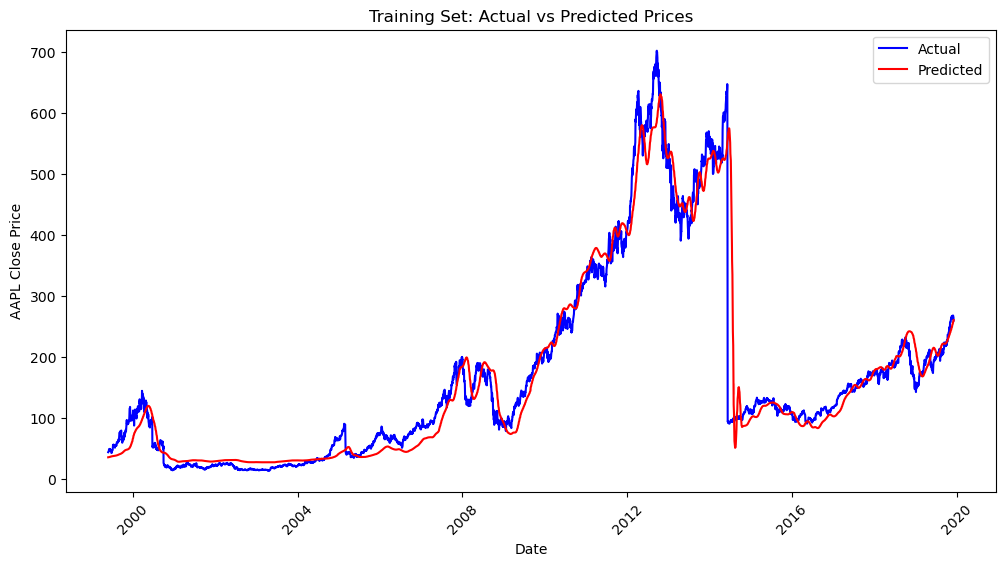

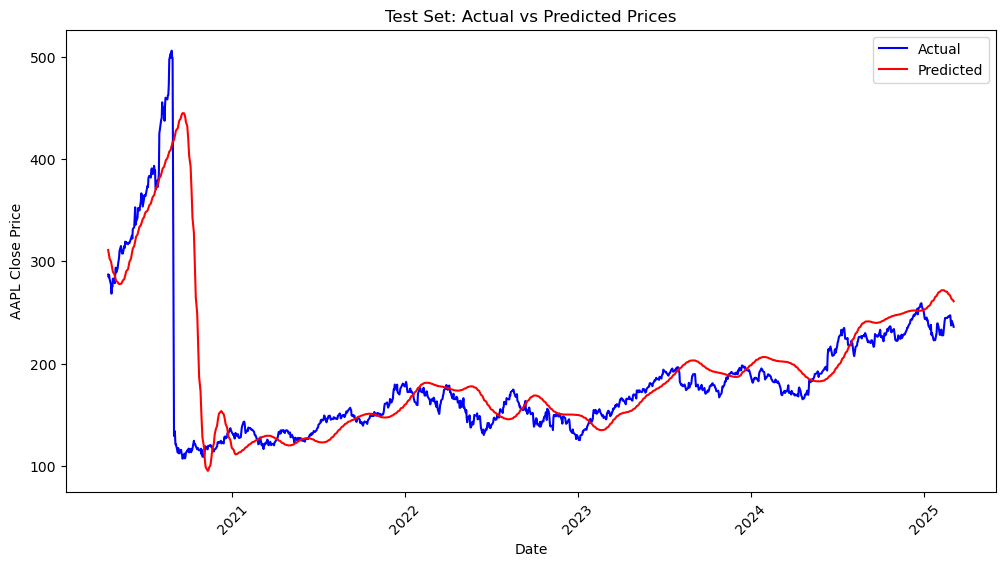

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


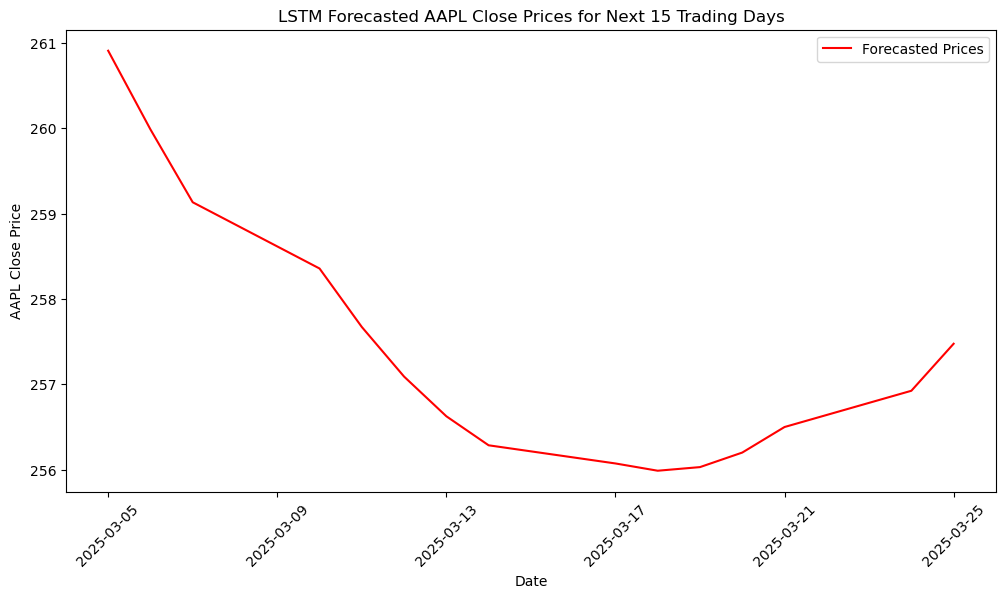

In [ ]:
# Building LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(seq_length, 1), kernel_regularizer=l1_l2(0.01, 0.01)))
lstm_model.add(Dropout(0.3)) # Dropout of 30%
BatchNormalization(axis=1)
lstm_model.add(LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer=l1_l2(0.01, 0.01)))
lstm_model.add(Dropout(0.4)) # Dropout of 40%
BatchNormalization(axis=1)
lstm_model.add(LSTM(32, activation='tanh', return_sequences=False))
lstm_model.add(Dropout(0.3)) # Dropout of 30%
BatchNormalization(axis=1)
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(1, activation='linear'))


lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)
optimizer = AdamW(learning_rate=lr_schedule)

# compiling the model
lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Training LSTM model
lstm_model.fit(X_train, y_train, batch_size=64, epochs=5, verbose=1)

# Predictions on the test set
y_train_pred = lstm_model.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred)  # Inverse transform predictions
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))  # Inverse transform actual values


# Compute RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Training RMSE: {train_rmse}')


# Predictions on the test set
y_pred = lstm_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)  # Inverse transform predictions
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # Inverse transform actual values


# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: {test_rmse}')

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_data['date'].iloc[seq_length:], y=y_train.flatten(), label='Actual', color='blue')
sns.lineplot(x=train_data['date'].iloc[seq_length:], y=y_train_pred.flatten(), label='Predicted', color='red')
plt.xlabel("Date")
plt.ylabel("AAPL Close Price")
plt.title("Training Set: Actual vs Predicted Prices")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
sns.lineplot(x=test_data['date'].iloc[seq_length:], y=y_test.flatten(), label='Actual', color='blue')
sns.lineplot(x=test_data['date'].iloc[seq_length:], y=y_pred.flatten(), label='Predicted', color='red')
plt.xlabel("Date")
plt.ylabel("AAPL Close Price")
plt.title("Test Set: Actual vs Predicted Prices")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Forecast the next 15 days
future_predictions = []
input_seq = X_test[-1].reshape(1, seq_length, 1)

for _ in range(15):
    pred = lstm_model.predict(input_seq)[0, 0]
    future_predictions.append(pred)
    new_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)
    input_seq = new_seq


# Convert forecasted values back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

# Create future dates
date_range = pd.date_range(start=pd.to_datetime(test_data['date'].max()) + pd.Timedelta(days=1), periods=15, freq='B')

# Plot forecasted prices
plt.figure(figsize=(12, 6))
sns.lineplot(x=date_range, y=future_predictions, label='Forecasted Prices', color='red')
plt.xlabel("Date")
plt.ylabel("AAPL Close Price")
plt.title("LSTM Forecasted AAPL Close Prices for Next 15 Trading Days")
plt.legend()
plt.xticks(rotation=45)
plt.show()

    date_range  future_predictions  AAPL_close
0  2025-03-05          260.909363  235.740000
1  2025-03-06          259.987030  235.330000
2  2025-03-07          259.133575  239.070000
3  2025-03-10          258.357391  227.480000
4  2025-03-11          257.672150  220.840000
5  2025-03-12          257.090851  216.980000
6  2025-03-13          256.625854  209.680000
7  2025-03-14          256.285767  213.490000
8  2025-03-17          256.072998  214.000000
9  2025-03-18          255.987808  212.690000
10 2025-03-19          256.030212  215.240000
11 2025-03-20          256.200623  214.100000
12 2025-03-21          256.500000  218.270000
13 2025-03-24          256.924713  220.730000
14 2025-03-25          257.475891  223.750000
Pearson Correlation between forecasted prices and actual prices: 0.9249104686794392  with a p-value of: 8.047873581637142e-07 
 Spearman Correlation between forecasted prices and actual prices: 0.8642857142857141  with a p-value of: 3.243373143346797e-05 
 Foreca

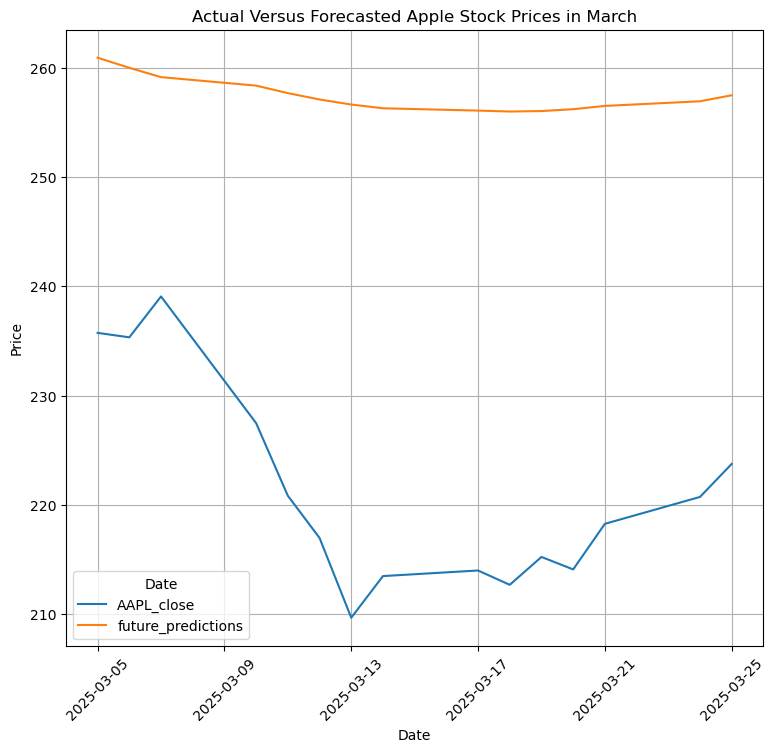

In [ ]:
apple_lstm = pd.DataFrame({"date_range": date_range,
                         "future_predictions": future_predictions})


apple_lstm = pd.concat([apple_lstm, apple_march_prices['AAPL_close']], axis=1)
print(f" {apple_lstm}")


# Assuming you have two columns: 'future_predictions' and 'AAPL_close'
correlation, p_value = pearsonr(apple_lstm['future_predictions'], apple_lstm['AAPL_close'])

# Calculate Spearman's correlation
spearman_corr, p_value_spear = spearmanr(apple_lstm['future_predictions'], apple_lstm['AAPL_close'])


# Calculate Pearson correlation
correlation = apple_lstm[['future_predictions', 'AAPL_close']].corr().iloc[0, 1]


rmse = np.sqrt(np.mean((apple_lstm['AAPL_close'] - apple_lstm['future_predictions'])**2)) # for our given stock price ranges, rmse between 5-10 is good but the lower the better

mae = np.mean(np.abs((apple_lstm['AAPL_close'] - apple_lstm['future_predictions']))) # similarly for mae, the lower the better

mape = np.mean(np.abs((apple_lstm['AAPL_close'] - apple_lstm['future_predictions']) / apple_lstm['AAPL_close'])) * 100 # aim for mape below 10% if possible


# Prioritising correlation overall is key. Hopefully the ARIMA model beats this correlation and improves the other metrics as well

print(f"Pearson Correlation between forecasted prices and actual prices: {correlation}  with a p-value of: {p_value} \n",
      f"Spearman Correlation between forecasted prices and actual prices: {spearman_corr}  with a p-value of: {p_value_spear} \n", 
       
      f"Forecasted Root Mean Squared Error: {rmse} \n",
      f"Forecasted Mean Absolute Error: {mae} \n",
      f"Mean Absolute Percentage Error: {mape} \n")

# reshaping data for plotting in seaborn
apple_melted = apple_lstm.melt(id_vars=['date_range'],
                               value_vars=['AAPL_close', 'future_predictions'],
                               var_name='Date',
                               value_name='Price')

# Plotting in Seaborn
plt.figure(figsize=(9, 8))
sns.lineplot(data=apple_melted, x='date_range', y='Price', hue='Date', markers='o')

# labels
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual Versus Forecasted Apple Stock Prices in March')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

# BI-LSTM Model for Apple

In [58]:
# Split data into train and test
split_date = np.quantile(s_appl['date_unix'], 0.8)
train_data = s_appl[s_appl['date_unix'] <= split_date]
test_data = s_appl[s_appl['date_unix'] > split_date]



# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 90  # Sequence length for LSTM

# Use the scaled 'MSFT_close_scaled' column for sequence creation
train_scaled = train_data[['AAPL_close_scaled']].values
test_scaled = test_data[['AAPL_close_scaled']].values

X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Epoch 1/10


c:\Users\ekf98\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


164/164 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - loss: 38.1297
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 34s 205ms/step - loss: 1.4249
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - loss: 0.6004
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 32s 192ms/step - loss: 0.3098
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 34s 206ms/step - loss: 0.2252
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 32s 193ms/step - loss: 0.1749
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 32s 197ms/step - loss: 0.1616
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 32s 197ms/step - loss: 0.1539
Epoch 9/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 35s 214ms/step - loss: 0.1493
Epoch 10/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 33s 200ms/step - loss: 0.1475
164/164 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step
Training RMSE: 43.00197733618403
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
Test RMSE: 50.66972548700083


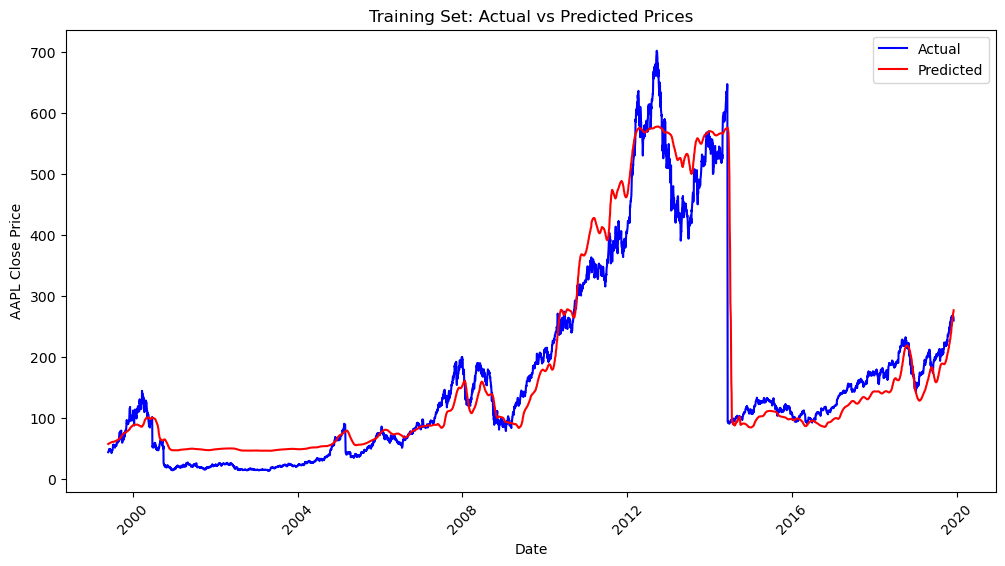

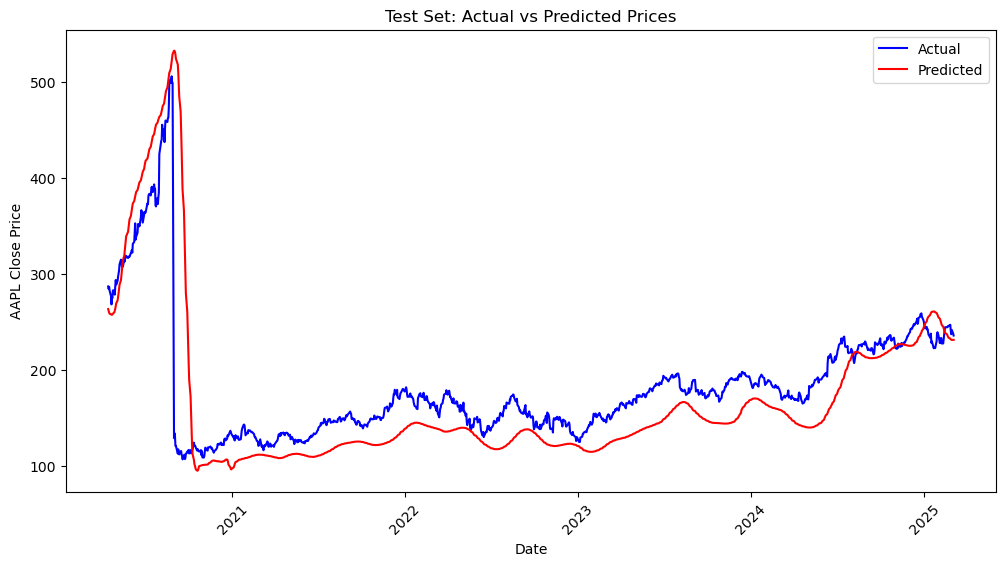

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


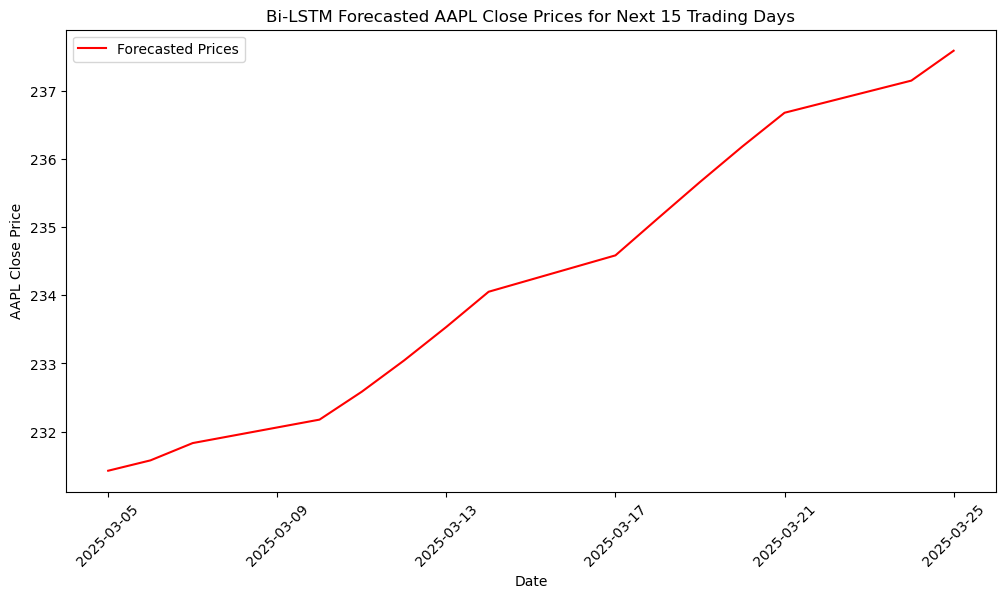

In [59]:
# Define Bidirectional LSTM Model
bilstm_model = Sequential([
    Bidirectional(LSTM(64, activation='tanh', kernel_regularizer=l1_l2(0.01, 0.01), return_sequences=True), input_shape=(seq_length, 1)),
    Dropout(0.3),
    BatchNormalization(),
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh', kernel_regularizer=l1_l2(0.01, 0.01))),
    Dropout(0.4),
    BatchNormalization(),
    Bidirectional(LSTM(32, activation='tanh', return_sequences=False)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])


lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)
bilstm_optimizer = AdamW(learning_rate=lr_schedule)

# Compile the bi-lstm model
bilstm_model.compile(optimizer=bilstm_optimizer, loss='mean_squared_error')

# Train the model
bilstm_model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predictions on the training set
y_train_pred = bilstm_model.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred)  # Inverse transform predictions
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))  # Inverse transform actual values


# Compute RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Training RMSE: {train_rmse}')


# Predictions on the test set
y_pred = bilstm_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)  # Inverse transform predictions
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # Inverse transform actual values

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: {rmse}')


# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_data['date'].iloc[seq_length:], y=y_train.flatten(), label='Actual', color='blue')
sns.lineplot(x=train_data['date'].iloc[seq_length:], y=y_train_pred.flatten(), label='Predicted', color='red')
plt.xlabel("Date")
plt.ylabel("AAPL Close Price")
plt.title("Training Set: Actual vs Predicted Prices")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
sns.lineplot(x=test_data['date'].iloc[seq_length:], y=y_test.flatten(), label='Actual', color='blue')
sns.lineplot(x=test_data['date'].iloc[seq_length:], y=y_pred.flatten(), label='Predicted', color='red')
plt.xlabel("Date")
plt.ylabel("AAPL Close Price")
plt.title("Test Set: Actual vs Predicted Prices")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Forecast the next 15 days
future_predictions = []
input_seq = X_test[-1].reshape(1, seq_length, 1)

for _ in range(15):
    pred = bilstm_model.predict(input_seq)[0, 0]
    future_predictions.append(pred)
    new_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)
    input_seq = new_seq

# Convert forecasted values back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()
# Create future dates
date_range = pd.date_range(start=pd.to_datetime(test_data['date'].max()) + pd.Timedelta(days=1), periods=15, freq='B')

# Plot forecasted prices
plt.figure(figsize=(12, 6))
sns.lineplot(x=date_range, y=future_predictions, label='Forecasted Prices', color='red')
plt.xlabel("Date")
plt.ylabel("AAPL Close Price")
plt.title("Bi-LSTM Forecasted AAPL Close Prices for Next 15 Trading Days")
plt.legend()
plt.xticks(rotation=45)
plt.show()

    date_range  future_predictions  AAPL_close
0  2025-03-05          231.428146  235.740000
1  2025-03-06          231.579895  235.330000
2  2025-03-07          231.833450  239.070000
3  2025-03-10          232.177261  227.480000
4  2025-03-11          232.586517  220.840000
5  2025-03-12          233.044479  216.980000
6  2025-03-13          233.535873  209.680000
7  2025-03-14          234.051361  213.490000
8  2025-03-17          234.584564  214.000000
9  2025-03-18          235.124680  212.690000
10 2025-03-19          235.659927  215.240000
11 2025-03-20          236.179443  214.100000
12 2025-03-21          236.674881  218.270000
13 2025-03-24          237.146210  220.730000
14 2025-03-25          237.584137  223.750000
Pearson Correlation between forecasted prices and actual prices: -0.5542421668152209  with a p-value of: 0.03203487205080512 
 Spearman Correlation between forecasted prices and actual prices: -0.4535714285714285  with a p-value of: 0.08948590014302728 
 Forecast

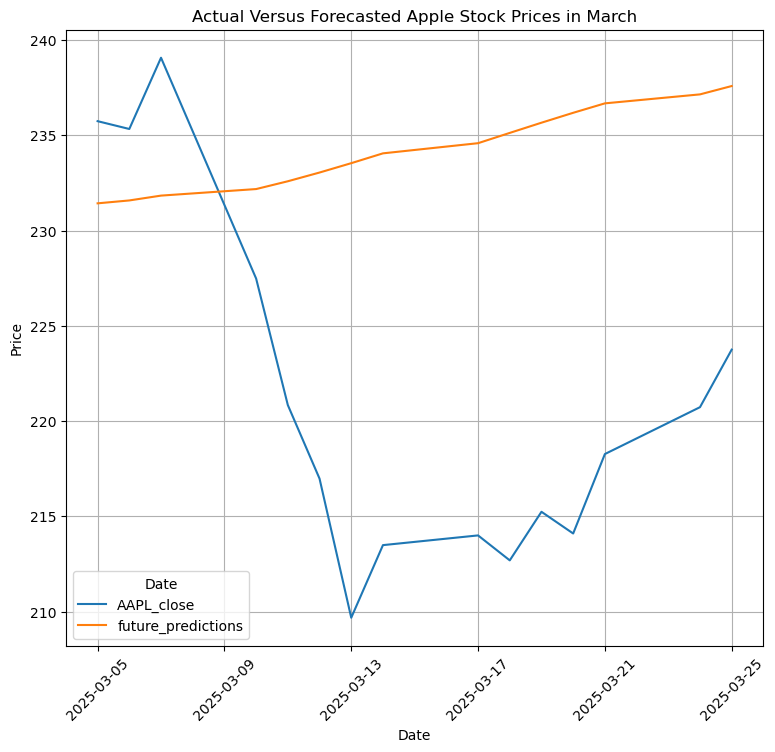

In [ ]:
apple_Bilstm = pd.DataFrame({"date_range": date_range,
                         "future_predictions": future_predictions})


apple_Bilstm = pd.concat([apple_Bilstm, apple_march_prices['AAPL_close']], axis=1)
print(f" {apple_Bilstm}")


# Assuming you have two columns: 'future_predictions' and 'NVDA_close'
correlation, p_value = pearsonr(apple_Bilstm['future_predictions'], apple_Bilstm['AAPL_close'])

# Calculate Spearman's correlation
spearman_corr, p_value_spear = spearmanr(apple_Bilstm['future_predictions'], apple_Bilstm['AAPL_close'])


# Calculate Pearson correlation
correlation = apple_Bilstm[['future_predictions', 'AAPL_close']].corr().iloc[0, 1]


rmse = np.sqrt(np.mean((apple_Bilstm['AAPL_close'] - apple_Bilstm['future_predictions'])**2)) # for our given stock price ranges, rmse between 5-10 is good but the lower the better

mae = np.mean(np.abs((apple_Bilstm['AAPL_close'] - apple_Bilstm['future_predictions']))) # similarly for mae, the lower the better

mape = np.mean(np.abs((apple_Bilstm['AAPL_close'] - apple_Bilstm['future_predictions']) / apple_Bilstm['AAPL_close'])) * 100 # aim for mape below 10% if possible


# Prioritising correlation overall is key. Hopefully the ARIMA model beats this correlation and improves the other metrics as well

print(f"Pearson Correlation between forecasted prices and actual prices: {correlation}  with a p-value of: {p_value} \n",
      f"Spearman Correlation between forecasted prices and actual prices: {spearman_corr}  with a p-value of: {p_value_spear} \n", 
       
      f"Forecasted Root Mean Squared Error: {rmse} \n",
      f"Forecasted Mean Absolute Error: {mae} \n",
      f"Mean Absolute Percentage Error: {mape} \n")

# reshaping data for plotting in seaborn
apple_melted = apple_Bilstm.melt(id_vars=['date_range'],
                               value_vars=['AAPL_close', 'future_predictions'],
                               var_name='Date',
                               value_name='Price')

# Plotting in Seaborn
plt.figure(figsize=(9, 8))
sns.lineplot(data=apple_melted, x='date_range', y='Price', hue='Date', markers='o')

# labels
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual Versus Forecasted Apple Stock Prices in March')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()